# Analyzing PPR Fantasy Football Running Back Data: Trends and Insights


The past is the best predictor of the future, and with the great importance fantasy football team managers place within predicting player success, finding trends in past data is a key factor towards achieving a fantasy championship. Using [FantasyPros](https://www.fantasypros.com/nfl/stats/rb.php?year=2023&scoring=PPR) and their database for past rushing, receiving, and PPR (point per reception) fantasy statistics for running backs, we can view which statistics, or combination of stats, coincide with higher or lower fantasy point per game totals. We want to find what statistics are the best predictors for future successes or failures for fantasy running backs, while also using the most influential features to make a model to predict 2024 outcomes and garner more insights on historical performances.

Here I will load the appropriate libraries and tools. Along with this, I load in the six dataframes from FantasyPros for each of the six years that I will be analyzing. I chose six years as I believe this gives enough historical insight into predicting stats and data for the 2024 season, but also because 2018 is when quarterback Patrick Mahomes played his first full season, ushering the newest era of football where passing offense is of far greater precedence than running the football and valuing the now almost 'expendable' running back.

The datasets come with a great deal of categories including the ones we will be using which are: ATT (Rushing Attempts), YDS (Rushing Yards), 20+ (20+ Yard Rushes), REC (Receptions), YDS.1 (Receiving Yards), G (Games Played), FPTS (Total Fantasy Points Scored), and FPTS/G (Fantasy Points Scored Per Game). The initial filter applied limits the data to only include players who had played in at least 6 games and had at least 50 touches. Also the following categories were created from data within the original dataframes: 20+/G (20+ Yard Rushes Per Game), TOT_YDS (Total Yards Accumulated), TOT_YDS/G (Total Yards Per Game), TOT_TD (Total Touchdowns Accumulated), YD/TCH (Average Yardage Gained Per Touch(ATT or REC)), and TCH/G (Average Touches Per Game). All of the columns have been turned into numeric values if possible and appropriately rounded. Lastly, the dropping of unneccesary columns and returning the trasformed data back to the original dataframes has occured.



In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import linregress
from sklearn.impute import SimpleImputer

In [110]:
PPR_RB_Fantasy_Data_2023 = pd.read_csv('/content/drive/MyDrive/Datasets/FullerFFPRBdata.csv')
PPR_RB_Fantasy_Data_2022 = pd.read_csv('/content/drive/MyDrive/Datasets/FullerFFPRBdata2.csv')
PPR_RB_Fantasy_Data_2021 = pd.read_csv('/content/drive/MyDrive/Datasets/FullerFFPRBdata3.csv')
PPR_RB_Fantasy_Data_2020 = pd.read_csv('/content/drive/MyDrive/Datasets/FullerFFPRBdata4.csv')
PPR_RB_Fantasy_Data_2019 = pd.read_csv('/content/drive/MyDrive/Datasets/FullerFFPRBdata5.csv')
PPR_RB_Fantasy_Data_2018 = pd.read_csv('/content/drive/MyDrive/Datasets/FullerFFPRBdata6.csv')

#place all 6 of the years of running back fantasy data in
rb_fantasy_years = [PPR_RB_Fantasy_Data_2023, PPR_RB_Fantasy_Data_2022, PPR_RB_Fantasy_Data_2021,
                    PPR_RB_Fantasy_Data_2020, PPR_RB_Fantasy_Data_2019, PPR_RB_Fantasy_Data_2018]

for i, fanyr in enumerate(rb_fantasy_years):
    # Apply the filter for 6 as minimum amount of games played and
    # minimum of 50 total season touches and create a copy
    fanyr = fanyr[(fanyr['G'] >= 6) & (fanyr['ATT'] + fanyr['REC'] >= 50)].copy()
    # Reset the Index
    fanyr.index = range(1, len(fanyr) + 1)

    fanyr.loc[:, 'YDS'] = fanyr.loc[:, 'YDS'].str.replace(',', '').astype(int)
    if 'YDS.1' in fanyr.columns and fanyr['YDS.1'].dtype == 'object':
        fanyr.loc[:, 'YDS.1'] = fanyr['YDS.1'].str.replace(',', '').astype(int)

    # Create and Round Categories '20+/G', 'TOT_YDS', 'TOT_YDS/GM', 'TOT_TD', 'YD/TCH'
    fanyr.loc[:, '20+/G'] = round((fanyr['20+'] / fanyr['G']), 2)
    fanyr.loc[:, 'TOT_YDS'] = round(pd.to_numeric(fanyr['YDS'] + fanyr['YDS.1']), 0)
    fanyr.loc[:, 'TOT_YDS/G'] = round(pd.to_numeric(fanyr['TOT_YDS'] / fanyr['G']), 2)
    fanyr.loc[:, 'TOT_TD'] = round(pd.to_numeric(fanyr['TD'] + fanyr['TD.1']), 0).astype(int)
    fanyr.loc[:, 'YD/TCH'] = round(((fanyr['Y/A'] * fanyr['ATT']) + (fanyr['Y/R'] * fanyr['REC'])) / (fanyr['ATT'] + fanyr['REC']), 2)
    # Round Categories '20+', 'REC', 'G', 'ATT'
    fanyr.loc[:, '20+'] = fanyr['20+'].round(0).astype(int)
    fanyr.loc[:, 'REC'] = fanyr['REC'].round(0).astype(int)
    fanyr.loc[:, 'G'] = fanyr['G'].round(0).astype(int)
    fanyr.loc[:, 'ATT'] = fanyr['ATT'].round(0).astype(int)
    fanyr.loc[:, 'TCH/G'] = round((fanyr['ATT'] + fanyr['REC']) / (fanyr['G']), 2)
    # Drop unnecessary columns
    fanyr = fanyr.drop(columns=['ROST', 'TGT', 'Rank', 'FL', 'LG', 'TD', 'TD.1', 'Y/A', 'Y/R'])
    # Ensure 'Player' is a string and clean up the names
    fanyr['Player'] = fanyr['Player'].astype(str).apply(lambda x: x.split(' (')[0])

    # Update the original DataFrame in the list
    rb_fantasy_years[i] = fanyr
# Assign the modified dataframes back after processing
PPR_RB_Fantasy_Data_2023, PPR_RB_Fantasy_Data_2022, PPR_RB_Fantasy_Data_2021, PPR_RB_Fantasy_Data_2020, PPR_RB_Fantasy_Data_2019, PPR_RB_Fantasy_Data_2018 = rb_fantasy_years


### Data Input
This next chunk of code is me adding the three categories AGE (Age of the player), OFF_RANK (The team's offensive yardage ranking of the team the player played on), and Majority Starter (Y if the player started more than half of the games they played in, and N if not). I manually input these values using data from the website [Pro Football Reference](https://www.pro-football-reference.com/years/2023/rushing.htm) and did so as I believed that these key metrics, which unlike the others listed previously, can be strong factors in determining fantasy performance while also being more easily predicted when projecting future performance. This will be touched on later.  

I then added a 'YEAR' column to each dataframe, but I also combined all of the data from the years 2019-2023 into one dataframe while further filtering  the data to only include players that averaged more than 10 touches
per game or qualified as a majority starter, all the while appearing in 8 or more games. I added the 'Round Picked' (Which round of their NFL draft the running back was selected in) column to the combined dataframe and since I input the 2018 data at a later time, I then added these last four columns of data to this dataframe. Lastly, I combined the data once more to make the dataframe of statistics from 2018-2023, which will be used for the analysis. I printed the first 10 and bottom 10 FPTS/G scorers of the dataframe.

In [111]:
#manually input the age, the total offensive yardage ranking for the team the player played on, and
#whether or not the player started more than half the games of which they played
#note: for players traded in-season, the proportion of the games played for each team was
#multiplied to each team's offensive ranking, added up, and rounded to the nearest whole number
PPR_RB_Fantasy_Data_2022.loc[:,'AGE'] = [27, 26, 24, 28, 25, 27, 22, 26, 25, 27,
                      25, 29, 28, 27, 27, 23, 22, 27, 24, 22,
                      25, 27, 23, 23, 31, 30, 25, 24, 32, 25,
                      30, 24, 22, 24, 27, 23, 23, 23, 24, 27,
                      28, 29, 21, 25, 23, 26, 24, 23, 23, 27,
                      25, 23, 23, 27, 23, 23, 24, 26, 25, 24,
                      23, 26, 26, 25, 33, 32, 24, 27, 26, 28,
                      24, 27, 25]

PPR_RB_Fantasy_Data_2023.loc[:,'AGE'] = [27, 23, 28, 31, 22, 22, 24, 21, 26, 24,
                      27, 24, 28, 24, 26, 29, 21, 25, 24, 23,
                      24, 28, 26, 24, 24, 29, 26, 25, 25, 25,
                      23, 28, 24, 28, 27, 21, 26, 25, 22, 25,
                      23, 25, 28, 25, 28, 26, 22, 24, 22, 25,
                      23, 24, 23, 25, 26, 21, 33, 24, 24, 24,
                      28, 23, 25, 27, 28, 24, 26, 23, 27, 28,
                      28, 32, 25, 27, 22]

PPR_RB_Fantasy_Data_2022.loc[:,'OFF_RANK'] = [9, 14, 12, 30, 18, 14, 25, 8, 11, 22, 26,
                           17, 15, 19, 7, 4, 13, 4, 23, 31, 3, 11,
                           27, 10, 24, 1, 28, 20, 21, 2, 6, 16, 24,
                           17, 5, 1, 32, 20, 28, 8, 16, 21, 25, 26, 15,
                           29, 15, 1, 25, 14, 32, 27, 22, 16, 2, 29,
                           23, 12, 9, 7, 3, 13, 10, 18, 19, 31, 24,
                           18, 4, 31, 13, 3, 16]

PPR_RB_Fantasy_Data_2023.loc[:,'OFF_RANK'] = [2, 7, 14, 1, 1, 31, 13, 3, 29, 23, 22, 15,
                           19, 9, 3, 28, 17, 27, 4, 21, 24, 18, 5,
                           8, 16, 11, 15, 30, 25, 25, 26, 6, 32, 30,
                           20, 6, 12, 20, 28, 10, 17, 24, 16, 11,
                           26, 6, 20, 10, 21, 10, 26, 8, 12, 5, 32,
                           14, 4, 19, 27, 9, 14, 22, 2, 7, 1, 19,
                           18, 24, 23, 29, 31, 17, 16, 13, 13]

#Y if the player started more than half the games of which the player played in ,
#N if they did not
PPR_RB_Fantasy_Data_2022.loc[:,'Majority Starter'] = ['Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N',
                                   'Y', 'N', 'Y', 'N', 'Y', 'Y', 'Y',
                                   'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y',
                                   'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'N',
                                   'Y', 'Y', 'Y', 'Y', 'N', 'N', 'N',
                                   'Y', 'Y', 'Y', 'N', 'N', 'N', 'Y',
                                   'Y', 'Y', 'N', 'Y', 'N', 'Y', 'Y',
                                   'N', 'Y', 'N', 'N', 'N', 'N', 'N',
                                   'N', 'N', 'N', 'N', 'N', 'N', 'N',
                                   'N', 'N', 'N', 'N', 'N', 'N', 'N',
                                   'N', 'N', 'N']
PPR_RB_Fantasy_Data_2023.loc[:,'Majority Starter'] = ['Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y',
                                    'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y',
                                    'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y',
                                    'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y',
                                    'N', 'Y', 'Y', 'Y', 'Y', 'N', 'Y',
                                    'N', 'Y', 'Y', 'N', 'Y', 'N', 'N',
                                    'N', 'N', 'N', 'N', 'N', 'N', 'N',
                                    'N', 'N', 'N', 'N', 'N', 'N', 'N',
                                    'N', 'N', 'N', 'N', 'N', 'N', 'N',
                                    'N', 'N', 'N', 'N', 'N', 'N', 'N',
                                    'N', 'N', 'N', 'N', 'N']

PPR_RB_Fantasy_Data_2021.loc[:,'AGE'] = [27, 22, 26, 26, 25, 26, 25, 23, 26, 22, 26,
                      26, 27, 23, 26, 30, 23, 24, 24, 23, 26, 24,
                      23, 28, 25, 21, 25, 22, 24, 28, 26, 22, 23,
                      24, 24, 25, 24, 24, 23, 29, 26, 26, 29, 26,
                      27, 26, 22, 27, 28, 24, 25, 23, 31, 24, 32,
                      22, 31, 31, 27, 25, 30, 27, 25, 26, 26, 26,
                      28, 24, 29, 27, 23, 28, 22, 27, 31, 23, 23,
                      27, 25, 24]
PPR_RB_Fantasy_Data_2021.loc[:,'OFF_RANK'] = [17, 16, 4, 2, 30, 28, 13, 23, 8, 22, 12,
                           18, 10, 11, 1, 29, 21, 15, 24, 7, 18, 9,
                           27, 19, 20, 19, 8, 3, 5, 21, 3, 26, 10,
                           1, 31, 17, 25, 14, 15, 6, 22, 17, 31, 14,
                           14, 9, 30, 11, 29, 5, 18, 12, 15, 26, 30,
                           14, 6, 32, 3, 16, 32, 20, 4, 17, 7, 13,
                           24, 2, 24, 11, 24, 26, 21, 27, 27, 20, 25,
                           30, 31, 28]
PPR_RB_Fantasy_Data_2021.loc[:,'Majority Starter'] = ['Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y',
                                   'Y', 'N', 'N', 'Y', 'Y', 'Y', 'Y',
                                   'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N',
                                   'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y',
                                   'Y', 'N', 'N', 'Y', 'N', 'N', 'Y',
                                   'N', 'Y', 'Y', 'N', 'N', 'Y', 'Y',
                                   'N', 'N', 'N', 'N', 'Y', 'N', 'N',
                                   'N', 'N', 'N', 'N', 'N', 'Y', 'N',
                                   'N', 'N', 'N', 'N', 'N', 'Y', 'N',
                                   'N', 'N', 'N', 'N', 'N', 'N', 'N',
                                   'N', 'N', 'N', 'N', 'N', 'N', 'N',
                                   'N', 'N', 'N']
PPR_RB_Fantasy_Data_2020.loc[:,'AGE'] = [25, 25, 26, 26, 22, 23, 25, 21, 24, 25, 23,
                      26, 22, 29, 25, 21, 22, 23, 27, 25, 21, 23,
                      27, 26, 25, 28, 24, 27, 25, 22, 22, 26, 30,
                      24, 25, 29, 26, 30, 25, 23, 23, 23, 21, 25,
                      30, 25, 28, 25, 28, 35, 23, 27, 23, 24, 27,
                      28, 37, 22, 25, 25, 26, 23, 28, 22, 24, 23,
                      31, 22, 22, 23, 32, 25, 26, 25, 25, 26, 25,
                      25, 29]
PPR_RB_Fantasy_Data_2020.loc[:,'OFF_RANK'] = [12, 4, 3, 5, 28, 26, 16, 10, 29, 9, 22,
                           17, 8, 13, 14, 20, 30, 24, 21, 16, 1, 7,
                           23, 6, 25, 15, 10, 30, 15, 22, 19, 18, 27,
                           6, 7, 29, 31, 12, 5, 27, 2, 11, 11, 15,
                           17, 27, 27, 19, 15, 20, 2, 13, 14, 9,
                           11, 7, 32, 4, 24, 18, 23, 9, 8, 32, 21,
                           32, 19, 25, 17, 20, 31, 29, 10, 18, 22,
                           30, 1, 3, 26]
PPR_RB_Fantasy_Data_2020.loc[:,'Majority Starter'] = ['Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y',
                                   'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y',
                                   'Y', 'N', 'Y', 'Y', 'Y', 'N', 'Y',
                                   'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'N',
                                   'N', 'Y', 'N', 'Y', 'N', 'N', 'N',
                                   'Y', 'Y', 'N', 'N', 'Y', 'Y', 'Y',
                                   'N', 'N', 'N', 'Y', 'N', 'N', 'N',
                                   'Y', 'N', 'N', 'N', 'N', 'N', 'N',
                                   'Y', 'N', 'N', 'N', 'Y', 'N', 'N',
                                   'N', 'N', 'N', 'Y', 'N', 'N', 'N',
                                   'N', 'N', 'N', 'N', 'N', 'N', 'N',
                                   'N', 'N']
PPR_RB_Fantasy_Data_2019.loc[:,'AGE'] = [23, 24, 25, 25, 24, 24, 22, 24, 24, 30, 24,
                      25, 25, 26, 21, 25, 24, 27, 23, 27, 22, 27,
                      23, 27, 25, 22, 24, 25, 28, 22, 22, 22, 24,
                      27, 24, 29, 26, 26, 29, 24, 34, 31, 23, 24,
                      29, 24, 29, 26, 23, 23, 23, 25, 25, 23, 22,
                      36, 22, 24, 24, 24, 21, 26, 26, 24, 21, 25,
                      28, 24, 29, 26, 25, 22, 24, 22, 31]

PPR_RB_Fantasy_Data_2019.loc[:,'OFF_RANK'] = [19, 16, 18, 12, 1, 10, 23, 9, 20, 2, 22,
                           8, 24, 10, 11, 7, 30, 32, 26, 5, 14, 15,
                           25, 6, 28, 24, 22, 14, 21, 29, 17, 3, 18,
                           4, 29, 9, 4, 13, 13, 15, 31, 6, 28, 14,
                           31, 4, 15, 11, 30, 8, 25, 3, 27, 21, 27,
                           24, 1, 2, 6, 5, 16, 17, 11, 27, 30, 25,
                           26, 27, 12, 7, 25, 17, 16, 2, 32]

PPR_RB_Fantasy_Data_2019.loc[:,'Majority Starter'] = ['Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y',
                                   'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y',
                                   'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y',
                                   'N', 'Y', 'Y', 'Y', 'Y', 'N', 'N',
                                   'Y', 'N', 'Y', 'Y', 'N', 'N', 'Y',
                                   'N', 'Y', 'N', 'Y', 'Y', 'Y', 'Y',
                                   'N', 'N', 'N', 'N', 'N', 'N', 'N',
                                   'N', 'N', 'N', 'Y', 'N', 'Y', 'N',
                                   'N', 'N', 'N', 'N', 'N', 'N', 'N',
                                   'N', 'N', 'N', 'N', 'N', 'N', 'N',
                                   'N', 'N', 'N', 'N', 'N']

PPR_RB_Fantasy_Data_2018.loc[:,'Majority Starter'] = ['Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y',
                                   'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y',
                                   'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'N',
                                   'Y', 'N', 'Y', 'Y', 'Y', 'N', 'N',
                                   'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'N',
                                   'N', 'N', 'N', 'Y', 'N', 'N', 'Y',
                                   'N', 'Y', 'N', 'N', 'N', 'Y', 'N',
                                   'Y', 'N', 'N', 'N', 'Y', 'Y', 'N',
                                   'N', 'N', 'N', 'N', 'N', 'N', 'N',
                                   'N', 'N', 'N', 'N', 'N', 'N', 'N',
                                   'N', 'N', 'N', 'N', 'N', 'N', 'N',
                                   'N', 'N', 'N', 'N', 'N']

#assign years to each year-by-year dataframe
PPR_RB_Fantasy_Data_2023.loc[:,'YEAR'] = 2023
PPR_RB_Fantasy_Data_2022.loc[:,'YEAR'] = 2022
PPR_RB_Fantasy_Data_2021.loc[:,'YEAR'] = 2021
PPR_RB_Fantasy_Data_2020.loc[:,'YEAR'] = 2020
PPR_RB_Fantasy_Data_2019.loc[:,'YEAR'] = 2019
PPR_RB_Fantasy_Data_2018.loc[:,'YEAR'] = 2018


#merge all of the yearly data dataframes into one, with the exclusion of the 2018 data
PPR_RB_Fantasy_Data_2018_2023 = pd.concat([PPR_RB_Fantasy_Data_2019, PPR_RB_Fantasy_Data_2020, PPR_RB_Fantasy_Data_2021,
                            PPR_RB_Fantasy_Data_2022, PPR_RB_Fantasy_Data_2023], ignore_index=True)
PPR_RB_Fantasy_Data_2018_2023 = PPR_RB_Fantasy_Data_2018_2023.sort_values('FPTS/G', ascending = False)
PPR_RB_Fantasy_Data_2018_2023 = PPR_RB_Fantasy_Data_2018_2023.reset_index(drop = True)
PPR_RB_Fantasy_Data_2018_2023 = PPR_RB_Fantasy_Data_2018_2023[((PPR_RB_Fantasy_Data_2018_2023['TCH/G'] > 10)
                                                |(PPR_RB_Fantasy_Data_2018_2023['Majority Starter']=='Y'))
                                                & (PPR_RB_Fantasy_Data_2018_2023['G'] >= 8)]
PPR_RB_Fantasy_Data_2018_2023.index = range(1, len(PPR_RB_Fantasy_Data_2018_2023) + 1)

#all of these columns are being turned into integers
PPR_RB_Fantasy_Data_2018_2023.loc[:,'G'] = PPR_RB_Fantasy_Data_2018_2023['G'].round(0).astype(int)
PPR_RB_Fantasy_Data_2018_2023.loc[:,'20+'] = PPR_RB_Fantasy_Data_2018_2023['20+'].round(0).astype(int)
PPR_RB_Fantasy_Data_2018_2023.loc[:,'REC'] = PPR_RB_Fantasy_Data_2018_2023['REC'].round(0).astype(int)
PPR_RB_Fantasy_Data_2018_2023.loc[:,'G'] = PPR_RB_Fantasy_Data_2018_2023['G'].round(0).astype(int)
PPR_RB_Fantasy_Data_2018_2023.loc[:,'ATT'] = PPR_RB_Fantasy_Data_2018_2023['ATT'].round(0).astype(int)
PPR_RB_Fantasy_Data_2018_2023.loc[:,'YDS.1'] = PPR_RB_Fantasy_Data_2018_2023['YDS.1'].astype(float).round(0).astype(int)
PPR_RB_Fantasy_Data_2018_2023.loc[:,'TOT_YDS'] = PPR_RB_Fantasy_Data_2018_2023['TOT_YDS'].round(0).astype(int)

#further filter the dataframe to only include players that average more than 10 touches
#per game or qualify as a majority starter, all the while appearing in 8 or more games
PPR_RB_Fantasy_Data_2018 = PPR_RB_Fantasy_Data_2018[((PPR_RB_Fantasy_Data_2018['TCH/G'] > 10)
                            |(PPR_RB_Fantasy_Data_2018['Majority Starter']=='Y'))
                            & (PPR_RB_Fantasy_Data_2018['G'] >= 8)]

#assign which round each player was drafted in their respective NFL draft
#note: let the number 8 denote an undrafted player, as only 7 rounds exist in the draft
PPR_RB_Fantasy_Data_2018_2023.loc[:,'Round Picked'] = ['1', '3', '1', '2', '2', '2', '8', '8', '5', '1',
                                   '2', '2', '5', '2', '1', '8', '1', '2', '1', '5',
                                   '1', '3', '2', '8', '3', '8', '1', '3', '1',
                                   '3', '1', '3', '2', '3', '2', '2', '1', '2',
                                   '8', '7', '1', '2', '1', '2', '2', '2', '1',
                                   '3', '2', '7', '4', '2', '3', '7', '1', '2', '3',
                                   '7', '3', '5', '1', '1', '3', '1', '3', '1', '1',
                                   '4', '1', '5', '2', '3', '1', '2', '1', '3', '2',
                                   '3', '2', '1', '4', '2', '3', '2', '3', '3', '1',
                                   '4', '6', '3', '2', '2', '2', '3', '3', '2', '1',
                                   '2', '4', '2', '8', '3', '1', '4', '1', '4',
                                   '3', '4', '8', '2', '3', '8', '2', '5', '8', '8',
                                   '1', '5', '3', '1', '1', '2', '1', '3', '2',
                                   '4', '8', '4', '8', '1', '1', '8', '3', '1',
                                   '8', '2', '2', '3', '3', '5', '6',
                                   '8', '4', '3', '1', '2', '4', '3', '4', '1',
                                   '2', '3', '8', '2', '4', '3', '1', '1',
                                   '2', '4', '7', '3', '5', '2', '8', '2', '3',
                                   '1', '2', '6', '3', '4', '2', '1', '2', '6',
                                   '3', '4', '4', '1', '4', '6', '4', '3', '6', '2',
                                   '8', '3', '4', '3', '1', '3', '3', '4', '1', '4',
                                   '2', '1', '3', '3',
                                   '3', '3', '8', '4', '5', '8', '3', '7', '3', '1',
                                   '2', '1', '3', '8', '3', '5', '8', '3'
                                   ,'4', '1']

PPR_RB_Fantasy_Data_2018 = PPR_RB_Fantasy_Data_2018.copy()

PPR_RB_Fantasy_Data_2018.loc[:,'AGE'] = [24, 21, 22, 23, 25, 23, 23, 23, 22, 26,
                      27, 23, 24, 22, 23, 24, 24, 21, 23, 24,
                      24, 25, 27, 23, 25, 23, 29, 33, 23, 24,
                      24, 25, 23, 24, 28, 24, 30, 28, 23, 29,
                      35, 22, 28, 27, 32]

PPR_RB_Fantasy_Data_2018.loc[:,'OFF_RANK'] = [2, 17, 10, 8, 11, 22, 4, 1, 26, 5,
                           32, 27, 19, 7, 21, 18, 12, 24, 20, 31,
                           25, 27, 15, 13, 6, 11, 8, 28, 16, 21,
                           9, 29, 5, 29, 25, 3, 30, 20, 9, 23,
                           31, 19, 21, 15, 24]

PPR_RB_Fantasy_Data_2018.loc[:,'Round Picked'] = [1, 1, 1, 3, 1, 1, 3, 3, 2, 4,
                               3, 1, 8, 4, 4, 7, 5, 2, 2, 3,
                               2, 2, 4, 2, 3, 8, 1, 1, 8, 5,
                               5, 8, 1, 6, 5, 8, 2, 6, 8, 1,
                               3, 3, 2, 6, 8]
PPR_RB_Fantasy_Data_2018.index = range(1, len(PPR_RB_Fantasy_Data_2018) + 1)
PPR_RB_Fantasy_Data_2018_2023 = pd.concat([PPR_RB_Fantasy_Data_2018, PPR_RB_Fantasy_Data_2018_2023]
                                          , ignore_index=True)
#PPR_RB_Fantasy_Data_2018_2023 = PPR_RB_Fantasy_Data_2018_2023.sort_values('FPTS/G', ascending = False)
print(PPR_RB_Fantasy_Data_2018_2023.sort_values('FPTS/G', ascending = False).head(10))
print(PPR_RB_Fantasy_Data_2018_2023.sort_values('FPTS/G', ascending = False).tail(10))


                 Player    ATT   YDS   20+    REC  YDS.1     G   FPTS  FPTS/G  \
45  Christian McCaffrey  287.0  1387   6.0  116.0   1005  16.0  471.2    29.5   
0        Todd Gurley II  256.0  1251  11.0   59.0  580.0  14.0  372.1    26.6   
46         Alvin Kamara  187.0   932   7.0   83.0    756  15.0  377.8    25.2   
47  Christian McCaffrey  272.0  1459   9.0   67.0    564  16.0  391.3    24.5   
48        Derrick Henry  219.0   937   3.0   18.0    154   8.0  193.3    24.2   
1        Saquon Barkley  261.0  1307  16.0   91.0  721.0  16.0  385.8    24.1   
2   Christian McCaffrey  219.0  1098   6.0  107.0  867.0  16.0  385.5    24.1   
49          Dalvin Cook  312.0  1557   6.0   44.0    361  14.0  337.8    24.1   
3          Alvin Kamara  194.0   883   1.0   81.0  709.0  15.0  354.2    23.6   
4     Melvin Gordon III  175.0   885   9.0   50.0  490.0  12.0  275.5    23.0   

    20+/G  TOT_YDS  TOT_YDS/G  TOT_TD  YD/TCH  TCH/G Majority Starter  YEAR  \
45   0.38   2392.0     149.50

### Exploration
Fantasy Football is all about finding the highest scorers in order to win weekly matchups. In this, we must find the highest FPTS/G scorers and the charecteristics that they have, as well as accumulation and per game stats to find what the highest scorers have in common. To understand what is a strong FPTS/G total in PPR (point per reception) scoring we must first look at the distribution of FPTS/G for the entire dataframe of 265 entries. The graphs and data below include this distribution plot, histograms showing FPTS/G for individual years, the summary statistics for the entire FPTS/G column, as well as for each year individually.

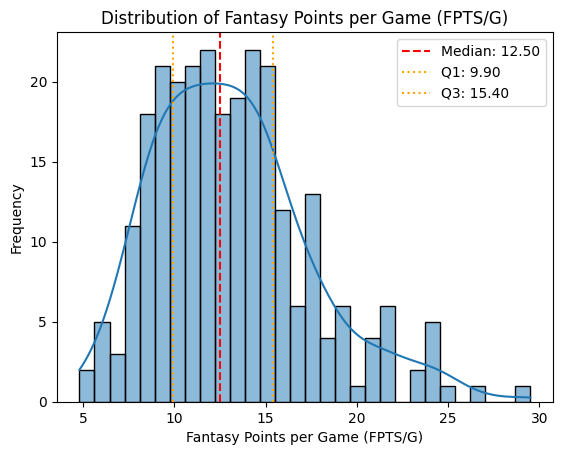

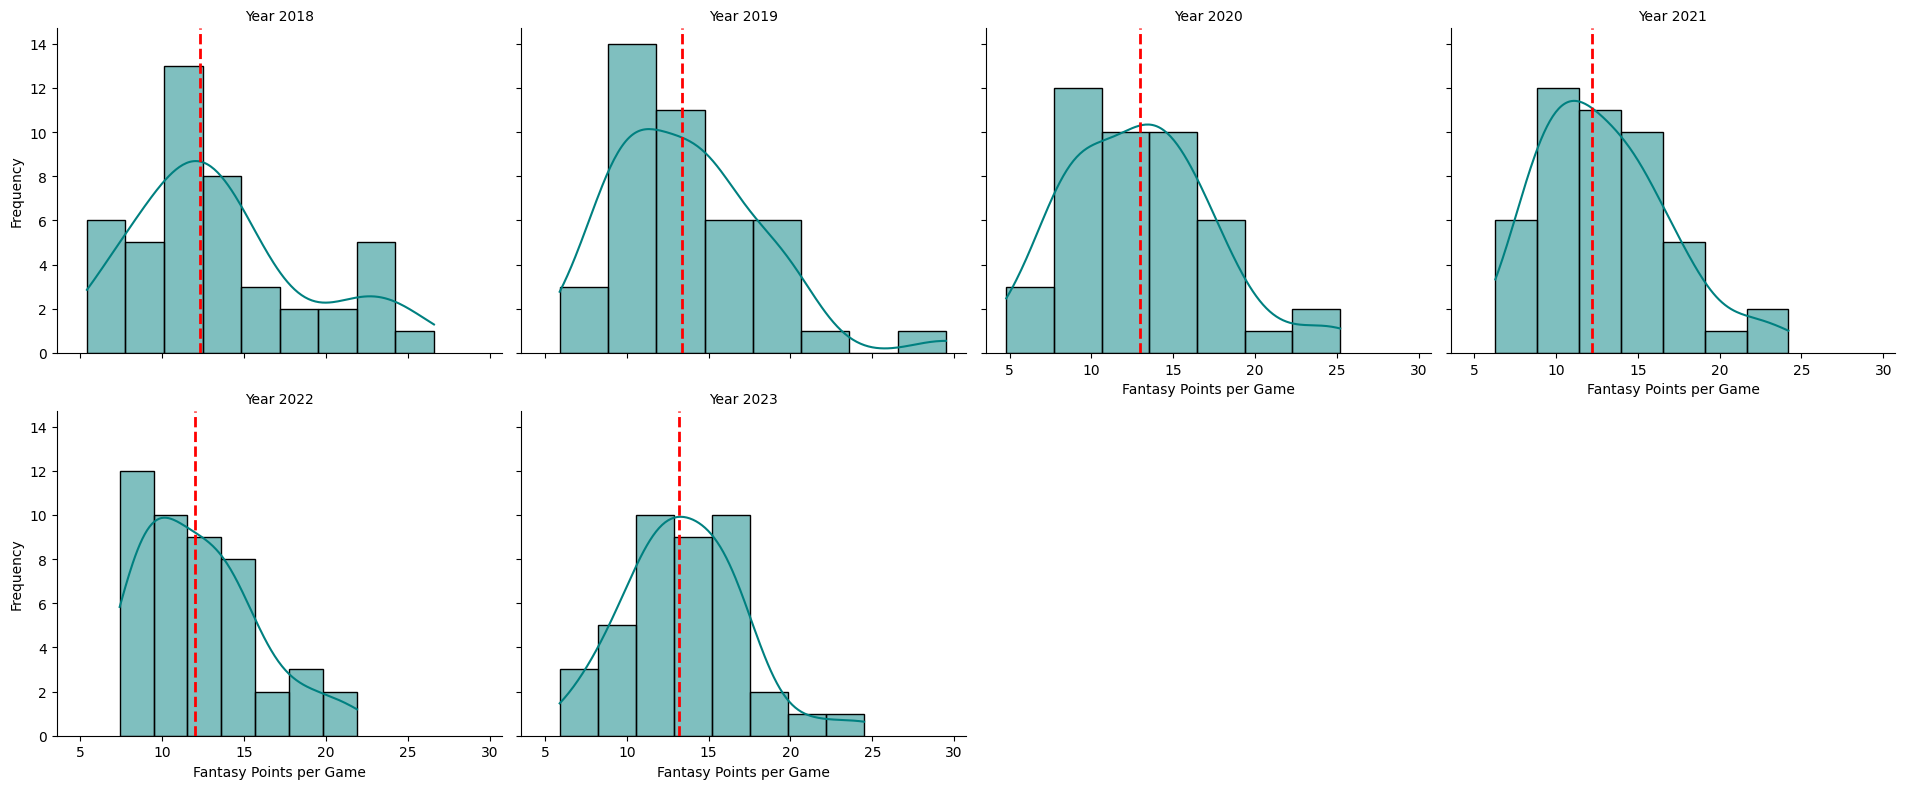

count    265.000000
mean      13.164528
std        4.296883
min        4.800000
25%        9.900000
50%       12.500000
75%       15.400000
max       29.500000
Name: FPTS/G, dtype: float64
      count       mean       std  min    25%    50%     75%   max
YEAR                                                             
2018   45.0  13.626667  5.338897  5.4  10.70  12.30  15.100  26.6
2019   42.0  13.626190  4.561721  5.9  10.25  13.35  15.875  29.5
2020   44.0  12.997727  4.478709  4.8   9.10  13.00  15.475  25.2
2021   47.0  12.987234  3.973806  6.3  10.00  12.20  15.200  24.2
2022   46.0  12.328261  3.624771  7.4   9.50  12.00  14.175  21.9
2023   41.0  13.504878  3.635172  5.9  11.20  13.20  15.700  24.5


In [112]:
PPR_RB_Fantasy_Data_2018_2023['Round Picked'] = pd.to_numeric(PPR_RB_Fantasy_Data_2018_2023['Round Picked'], errors='coerce')

# fpts/g distribution plot
median = PPR_RB_Fantasy_Data_2018_2023['FPTS/G'].median()
q1 = PPR_RB_Fantasy_Data_2018_2023['FPTS/G'].quantile(0.25)
q3 = PPR_RB_Fantasy_Data_2018_2023['FPTS/G'].quantile(0.75)
sns.histplot(PPR_RB_Fantasy_Data_2018_2023['FPTS/G'], kde=True, bins=30)
plt.xlabel('Fantasy Points per Game (FPTS/G)')
plt.ylabel('Frequency')
plt.title('Distribution of Fantasy Points per Game (FPTS/G)')
plt.axvline(median, color='r', linestyle='--', label=f'Median: {median:.2f}')
plt.axvline(q1, color='orange', linestyle=':', label=f'Q1: {q1:.2f}')
plt.axvline(q3, color='orange', linestyle=':', label=f'Q3: {q3:.2f}')
plt.legend()
plt.show()


#facted grid viewing fpts/g by year
g = sns.FacetGrid(PPR_RB_Fantasy_Data_2018_2023, col='YEAR', col_wrap=4, height=4, aspect=1.2)

#adds a median line
def add_median_line(data, **kwargs):
    median = data['FPTS/G'].median()
    plt.axvline(median, color='red', linestyle='dashed', linewidth=2)

g.map(sns.histplot, 'FPTS/G', kde=True, color='teal')
g.map_dataframe(add_median_line)
g.set_axis_labels('Fantasy Points per Game', 'Frequency')
g.set_titles(col_template='Year {col_name}')
g.add_legend()

plt.show()


print(PPR_RB_Fantasy_Data_2018_2023['FPTS/G'].describe())
print(PPR_RB_Fantasy_Data_2018_2023.groupby('YEAR')['FPTS/G'].describe())

From the graphs and tables of summary statistics, we see that the mean is around 13.16 fantasy points per game and the median is 12.5 fantasy points per game. The graphs do tend to be right skewed, as averages tend to be closer to 12 to 13.5 FPTS/G, yet we do see some values around the middle to high 20s. While the data that is being used is greatly filtered to only include each year's about top 45 players, one should understand that many players record significant FPTS per year, it is just that the data would be best suited for predicting the top scorers if we only look at the highest scorers who play and start the most games.
### Correlation Between Features
Next we will look at some heatmaps from seaborn. These heatmaps will show us which variables have the highest correlation which each other, meaning which variables in combination with each other have the strongest relationship, either positive or negative. When I initially created the first heatmap, I expected to see stronger correlations with some of the variables, such as with AGE and OFF_RANK. I then thought of what I could do to see if I could find any disparities in correlations, and I came about what a lot of football experts are speaking on nowadays, which is the effect of usage and age on NFL running backs. I found the median age of running backs in my data, then created two more heatmaps to compare correlations between features for running backs above the median age, and running backs below and at the median age.


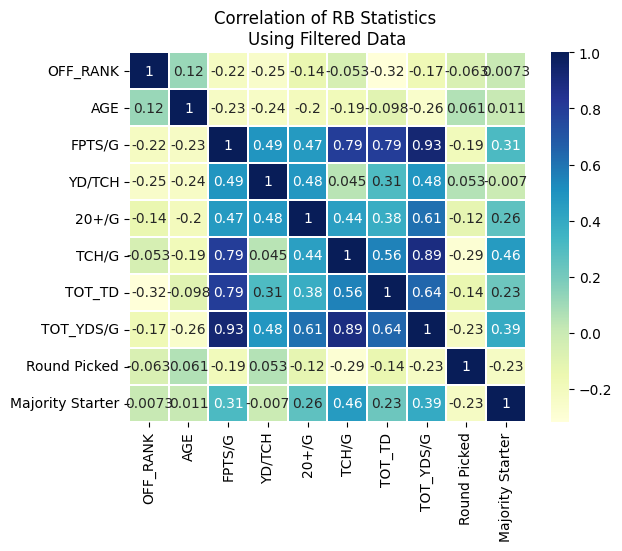

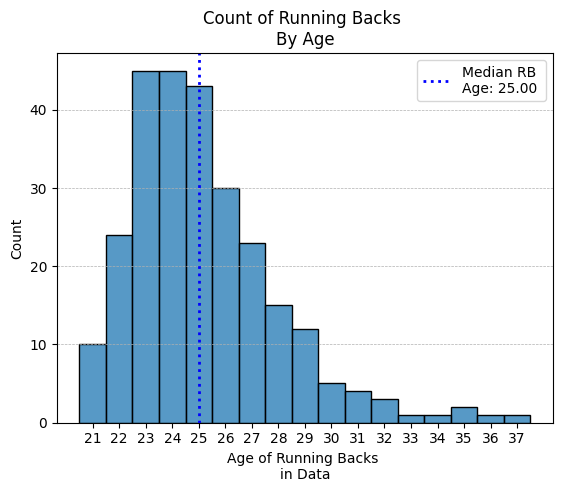

count    265.000000
mean      25.196226
std        2.797318
min       21.000000
25%       23.000000
50%       25.000000
75%       27.000000
max       37.000000
Name: AGE, dtype: float64


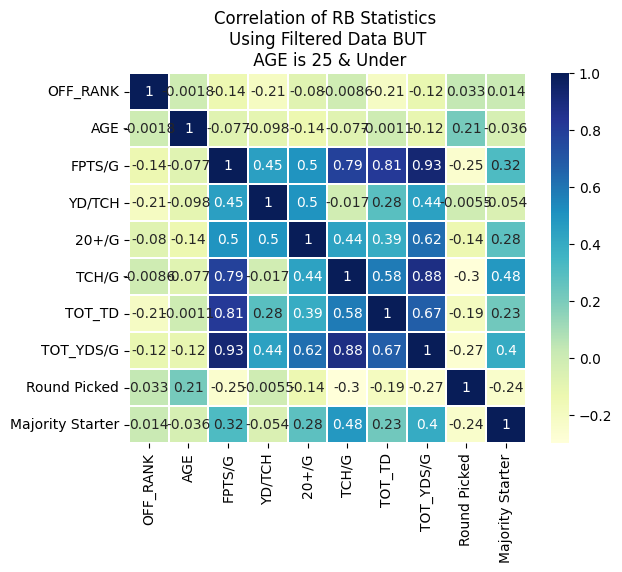

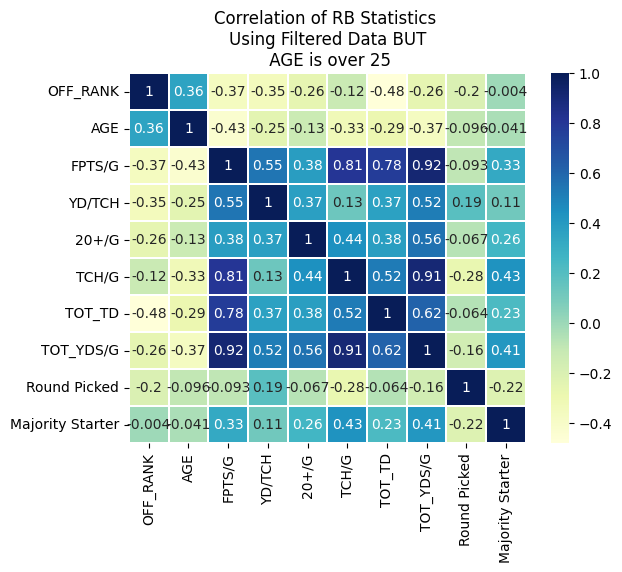

In [113]:
#changed Y and N values in column 'Majority Starter to the number 1 for Y and 0 for N
PPR_RB_Fantasy_Data_2018_2023['Majority Starter'] = PPR_RB_Fantasy_Data_2018_2023['Majority Starter'].map({'Y': 1, 'N': 0})

#heatmap that displays correlation between variables in the dataframe
sns.heatmap(PPR_RB_Fantasy_Data_2018_2023[['OFF_RANK', 'AGE', 'FPTS/G', 'YD/TCH', '20+/G', 'TCH/G',
                             'TOT_TD', 'TOT_YDS/G', 'Round Picked', 'Majority Starter']].corr(), cmap = 'YlGnBu', annot = True,
            linewidths = .3)
plt.title('Correlation of RB Statistics \nUsing Filtered Data')
plt.show()

#creating bins for histogram of running backs by age
bins = np.arange(20.5, 38.5, 1)

#histogram of count of running backs by age in the data
sns.histplot(PPR_RB_Fantasy_Data_2018_2023['AGE'], kde=False, bins=bins)
plt.xticks(range(21, 38))
plt.grid(True, axis='y', linestyle = '--', linewidth=0.5)
plt.xlabel('Age of Running Backs \nin Data')
plt.title('Count of Running Backs \nBy Age')
med_age = np.median(PPR_RB_Fantasy_Data_2018_2023['AGE'])
plt.axvline(med_age, linewidth = 2, color = 'b',
            linestyle = ':', label=f'Median RB \nAge: {med_age:.2f}')
plt.legend()
plt.show()

#summary statistics of the AGE column
print(PPR_RB_Fantasy_Data_2018_2023['AGE'].describe())

#with thte filter of AGE <= 25, heatmap that displays correlation between variables in the dataframe
sns.heatmap(PPR_RB_Fantasy_Data_2018_2023[PPR_RB_Fantasy_Data_2018_2023['AGE']<=25][['OFF_RANK', 'AGE', 'FPTS/G', 'YD/TCH', '20+/G', 'TCH/G',
                             'TOT_TD', 'TOT_YDS/G', 'Round Picked', 'Majority Starter']].corr(), cmap = 'YlGnBu', annot = True,
            linewidths = .3)
plt.title('Correlation of RB Statistics \nUsing Filtered Data BUT\n AGE is 25 & Under')
plt.show()

#with the filter of AGE > 25, heatmap that displays correlation between variables in the dataframe
sns.heatmap(PPR_RB_Fantasy_Data_2018_2023[PPR_RB_Fantasy_Data_2018_2023['AGE']>25][['OFF_RANK', 'AGE', 'FPTS/G', 'YD/TCH', '20+/G', 'TCH/G',
                             'TOT_TD', 'TOT_YDS/G', 'Round Picked', 'Majority Starter']].corr(), cmap = 'YlGnBu', annot = True,
            linewidths = .3)
plt.title('Correlation of RB Statistics \nUsing Filtered Data BUT\n AGE is over 25')
plt.show()

The darker the values the stronger the correlation and positive linear relationship between two variables. The
closer the color is from yellow to white, the stronger the negative linear relationship is. From the first
heatmap of all the data we can see the strongest relationships being in darkblue between the variables FPTS/G with
TCH/G, TOT_TD, and TOT_YDS/G. We also see darker blue and stronger associations with TOT_YDS/G with 20+/G, TCH/G,
and TOT_TD, as they all have correlations between 0.6 and 1, but we will focus on what is associated with FPTS/G
mostly. The relationship between FPTS/G with YD/TCH, 20+/G, and Majority Starter are moderately strong, while the
relationship with OFF_RANK, AGE, and Round Picked are fairly weak in comparison. While it looks like TCH/G, TOT_TD,
and TOT_YDS/G may be the best predictors from the 0.79, 0.79, and 0.93 values respectively with FPTS/G, I decided to split the
data by age to see if splitting it could find some stronger relationships with other statistics for either the older
half of running backs or the younger half of running backs.
### Splitting the Data
The histogram shows the count of running backs by age in the dataframe, and the summary statistics for the dataframe's 'AGE' column shows that the median age is 25 years old, so that is where I will split the data. There are far more ages available in the data over 25 than under 25, so I will include the age of 25 with the younger half, and have the other half be 26 and over.

While some of the boxes have similar correlations, some have a decent deal of disparity between the two new heatmaps. What can be seen in these features' correlations with FPTS/G is that across the two new graphs, for both the one with ages above 25 and the one with gaes 25 and below, TCH/G, TOT_TDS, TOT_YDS/G, and Majority Starter have comparable values across both, from .79 to 0.93. FPTS/G and its positive relationship increases by 0.1 with YD/TCH in players above 25 as opposed to at or below the age, and alternatively is 0.12 weaker when comparing 20+/G. What can be drawn from this is that older players may need to separate themselves and perform better than younger players in the YD/TCH category in order to see the field more, while the older players also lack some of the explosiveness and 20+ yard rushes that younger players tend to experience more.

The three biggest differences in correlation with FPTS/G between the two graphs are OFF_RANK, AGE, and Round Picked. The correlations are 0.23 and .353 points stronger in the older players for OFF_RANK and AGE, respectively, meaning that as the player ages it matters more how old they are and how good they're offense is more so in producing fantasy points. When the player is younger, it does not matter as much but as they get older, a poor offense and more mileage on the player's body become extra hurdles in attempting to become viable fantasy options and competing with younger, more projectable players. The 'Round Picked' category is actually .157 points stronger in the younger group, which can likely be explained as players selected in earlier rounds produce more, and the players that do not produce tend to get fazed out of the NFL. This can lead to there being less parity in older players being selected in a plethora of rounds, or this could allign with less disparity in scores in older players, as older players tend to score less than younger players and have less big seasons for the most part.

### Linear Analysis

Now we will look at some linear regression graphs to better visualize different variables relationships with FPTS/G. We'll take a look at a few of the variables that initially had a strong correlation with FPTS/G, regardless of age. Below are the graphs with FPTS/G on the y axis along with YD/TCH, 20+/G, TCH/G, and TOT_YDS/G. The equations for the regression lines are displayed on the graphs. For the two graphs involving touches or TCH, the size and darkness of the circles or datapoints are determined by ATT or attempts, while the other two graphs have the points determined by AGE.

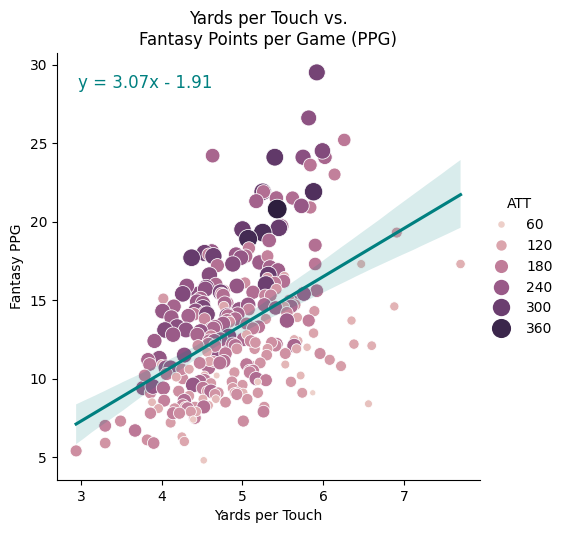

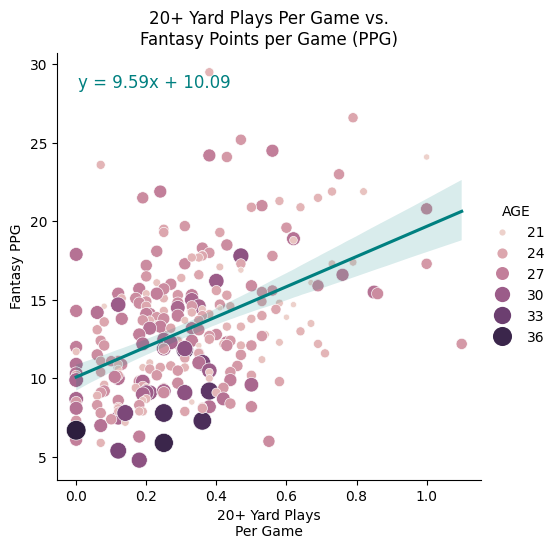

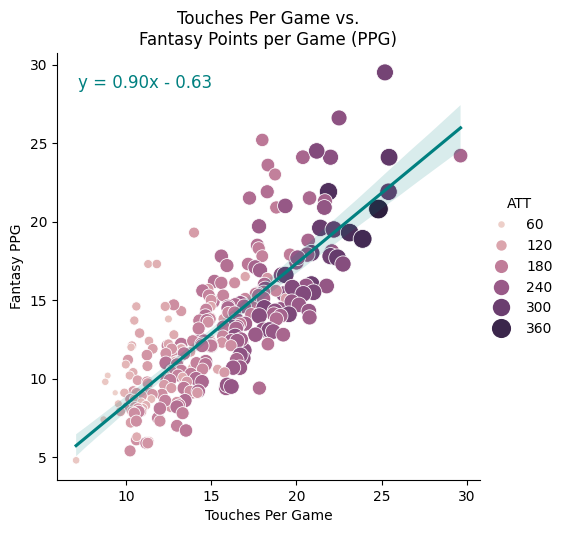

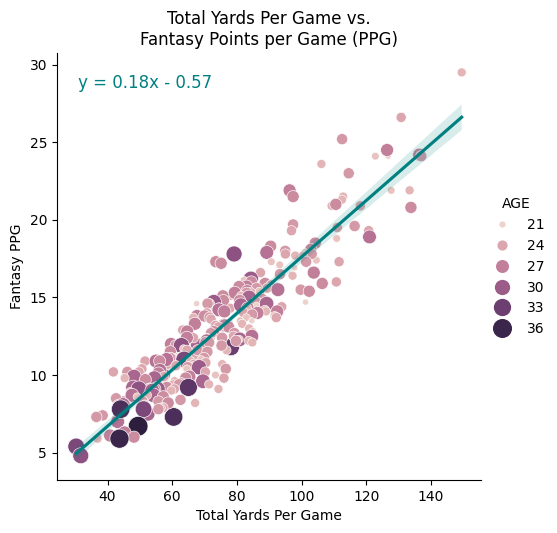

In [114]:
#FOR ALL YEARS
#regression and relational plot of YD/TCH vs FPTS/G
x = sns.relplot(x = 'YD/TCH', y = 'FPTS/G', data = PPR_RB_Fantasy_Data_2018_2023, kind = 'scatter', size = 'ATT',
            hue='ATT', sizes=(20, 200))
sns.regplot(x = 'YD/TCH', y = 'FPTS/G', data = PPR_RB_Fantasy_Data_2018_2023, scatter = False, color = 'teal')
x.set(xlabel = 'Yards per Touch', ylabel = 'Fantasy PPG',
      title = 'Yards per Touch vs.\nFantasy Points per Game (PPG)')
slope, intercept, r_value, p_value, std_err = linregress(PPR_RB_Fantasy_Data_2018_2023['YD/TCH'],
                                                         PPR_RB_Fantasy_Data_2018_2023['FPTS/G'])

# Annotate the equation on the plot
plt.annotate(f'y = {slope:.2f}x - {abs(intercept):.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, color='teal',
             horizontalalignment='left', verticalalignment='top')
plt.show()



#regression and relational plot of 20+/G vs FPTS/G
x1 = sns.relplot(x = '20+/G', y = 'FPTS/G', data = PPR_RB_Fantasy_Data_2018_2023, kind = 'scatter', size = 'AGE',
                 hue = 'AGE', sizes = (20, 200))
sns.regplot(x = '20+/G', y = 'FPTS/G', data = PPR_RB_Fantasy_Data_2018_2023, scatter = False, color = 'teal')
x1.set(xlabel = '20+ Yard Plays\nPer Game', ylabel = 'Fantasy PPG',
      title = '20+ Yard Plays Per Game vs.\nFantasy Points per Game (PPG)')
slope, intercept, r_value, p_value, std_err = linregress(PPR_RB_Fantasy_Data_2018_2023['20+/G'],
                                                         PPR_RB_Fantasy_Data_2018_2023['FPTS/G'])

# Annotate the equation on the plot
plt.annotate(f'y = {slope:.2f}x + {intercept:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, color='teal',
             horizontalalignment='left', verticalalignment='top')
plt.show()



#regression and relational plot of TCH/G vs FPTS/G
x = sns.relplot(x = 'TCH/G', y = 'FPTS/G', data = PPR_RB_Fantasy_Data_2018_2023, kind = 'scatter', size = 'ATT',
            hue='ATT', sizes=(20, 200))
sns.regplot(x = 'TCH/G', y = 'FPTS/G', data = PPR_RB_Fantasy_Data_2018_2023, scatter = False, color = 'teal')
x.set(xlabel = 'Touches Per Game', ylabel = 'Fantasy PPG',
      title = 'Touches Per Game vs.\nFantasy Points per Game (PPG)')
slope, intercept, r_value, p_value, std_err = linregress(PPR_RB_Fantasy_Data_2018_2023['TCH/G'],
                                                         PPR_RB_Fantasy_Data_2018_2023['FPTS/G'])

# Annotate the equation on the plot
plt.annotate(f'y = {slope:.2f}x - {abs(intercept):.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, color='teal',
             horizontalalignment='left', verticalalignment='top')
plt.show()



#regression and relational plot of TOT_YDS/G vs FPTS/G
x = sns.relplot(x = 'TOT_YDS/G', y = 'FPTS/G', data = PPR_RB_Fantasy_Data_2018_2023, kind = 'scatter', size = 'AGE',
            hue='AGE', sizes=(20, 200))
sns.regplot(x = 'TOT_YDS/G', y = 'FPTS/G', data = PPR_RB_Fantasy_Data_2018_2023, scatter = False, color = 'teal')
x.set(xlabel = 'Total Yards Per Game', ylabel = 'Fantasy PPG',
      title = 'Total Yards Per Game vs.\nFantasy Points per Game (PPG)')
slope, intercept, r_value, p_value, std_err = linregress(PPR_RB_Fantasy_Data_2018_2023['TOT_YDS/G'],
                                                         PPR_RB_Fantasy_Data_2018_2023['FPTS/G'])

# Annotate the equation on the plot
plt.annotate(f'y = {slope:.2f}x - {abs(intercept):.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, color='teal',
             horizontalalignment='left', verticalalignment='top')
plt.show()


As seen with the stronger correlations, we can see that these graphs have strong positive and linear relationships. Take note that for the first and third graphs and their key, players with more attempts tend to be farther along or above the regression line. Conversely for the second and fourth graphs, the bigger circles tend to be at the bottom of the line and below the data, communicating that older players were not as productive in both of the categories shown.
### Splitting Graphs
The previous four graphs have done well in showing that the four variables displayed alongside FPTS/G can be strong predictors based on our historical data being used. The next few graphs don't show as much of a strong indication of being powerful predictors, but splitting the graphs by age, like we did with the heatmap, can show that the relationships exhibited may still be useful even if it only affects one half of the data.

We saw with the correlations that FPTS/G had the biggest differences with 'Round Picked', 'AGE', and 'OFF_RANK'. The relationships with these variables and FPTS/G are displayed below, with each of the three variables also having three graphs: one for the entire data, one for players under and at the age of 25, and one with players above 25. The slopes of the graphs are displayed in the top left corner and the graphs have the same rules as the previous regression plots displayed.

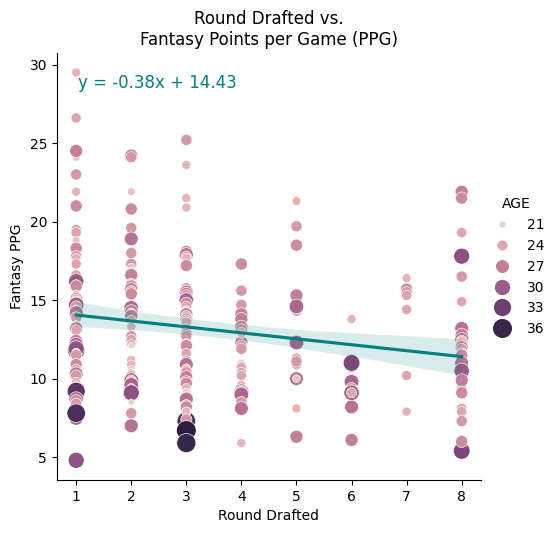

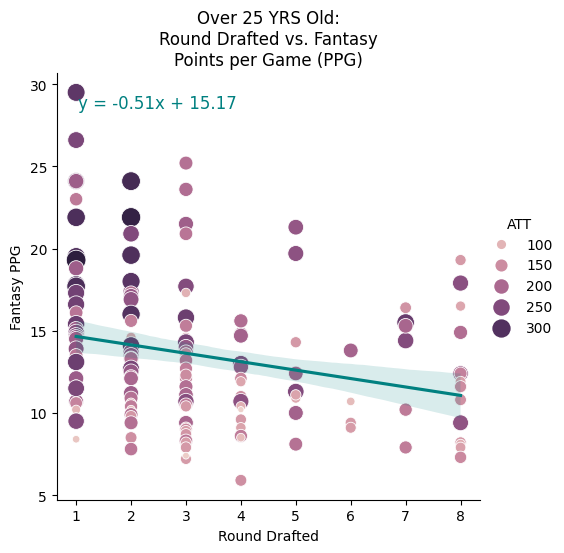

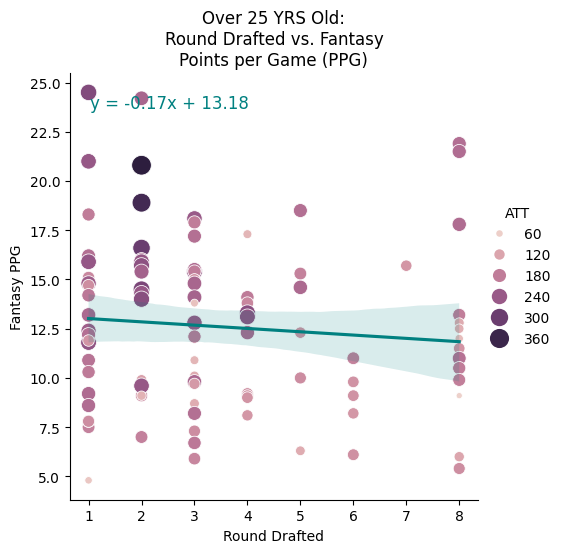

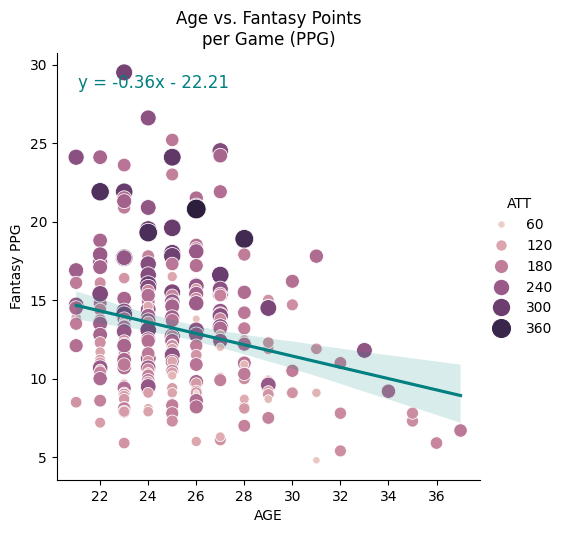

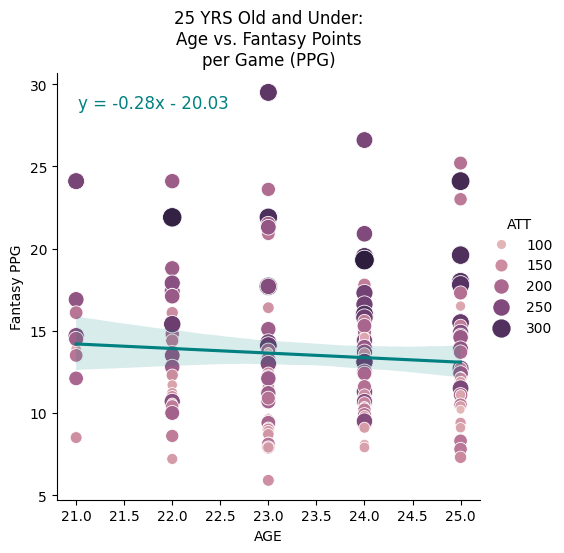

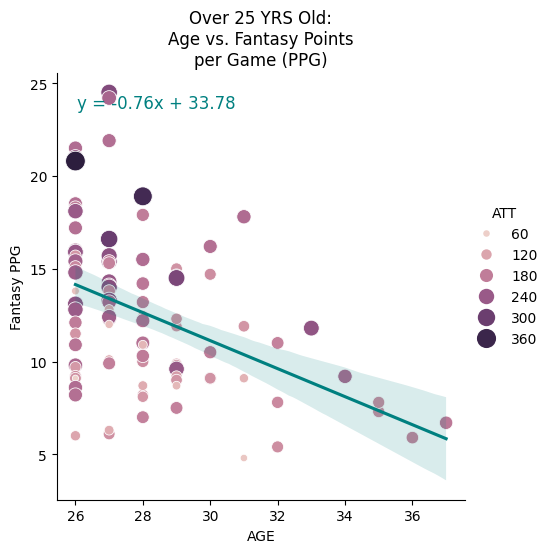

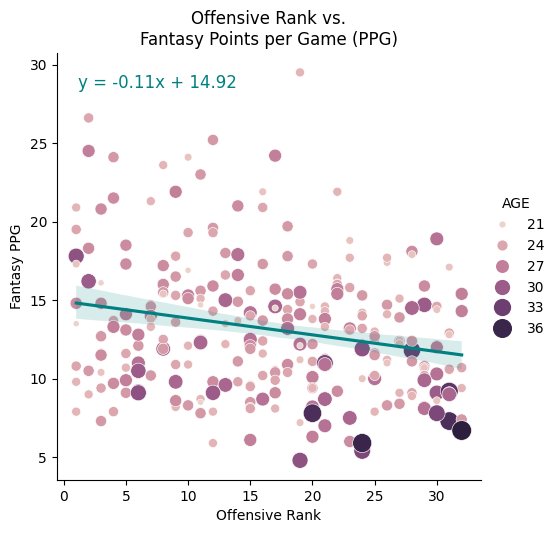

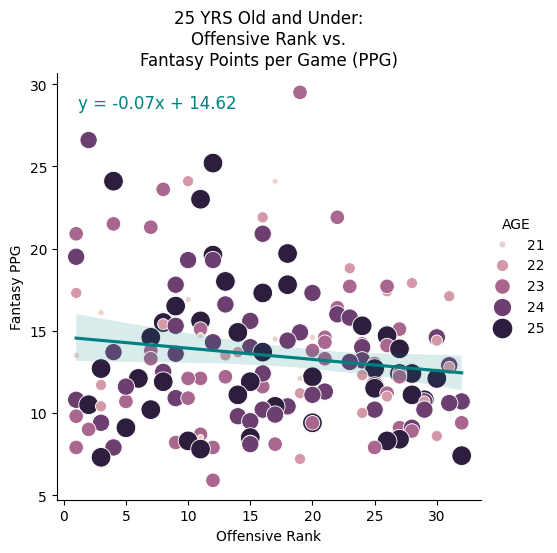

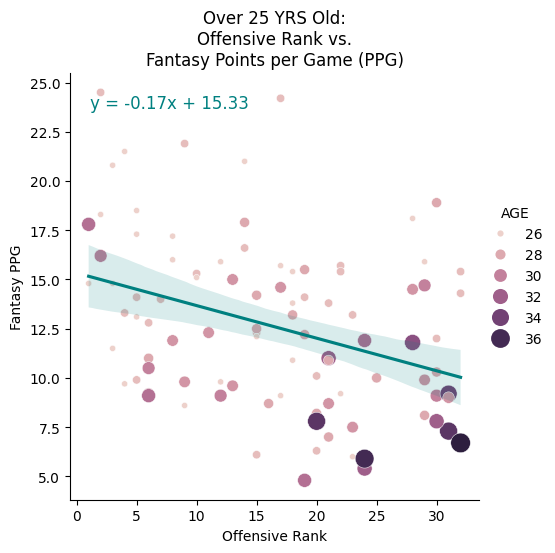

In [115]:
x = sns.relplot(x = 'Round Picked', y = 'FPTS/G', data = PPR_RB_Fantasy_Data_2018_2023, kind = 'scatter', size = 'AGE',
            hue='AGE', sizes=(20, 200))
sns.regplot(x = 'Round Picked', y = 'FPTS/G', data = PPR_RB_Fantasy_Data_2018_2023, scatter = False, color = 'teal')
x.set(xlabel = 'Round Drafted', ylabel = 'Fantasy PPG',
      title = 'Round Drafted vs.\nFantasy Points per Game (PPG)')
slope, intercept, r_value, p_value, std_err = linregress(PPR_RB_Fantasy_Data_2018_2023['Round Picked'],
                                                         PPR_RB_Fantasy_Data_2018_2023['FPTS/G'])

# Annotate the equation on the plot
plt.annotate(f'y = {slope:.2f}x + {abs(intercept):.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, color='teal',
             horizontalalignment='left', verticalalignment='top')
plt.show()

# With the filter of AGE <= 25, regression and relational plot of 'Round Picked' vs 'FPTS/G'
x = sns.relplot(x = 'Round Picked', y = 'FPTS/G', data = PPR_RB_Fantasy_Data_2018_2023[PPR_RB_Fantasy_Data_2018_2023['AGE'] <= 25],
                kind = 'scatter', size = 'ATT', hue='ATT', sizes=(20, 200))
sns.regplot(x = 'Round Picked', y = 'FPTS/G', data = PPR_RB_Fantasy_Data_2018_2023[PPR_RB_Fantasy_Data_2018_2023['AGE'] <= 25],
            scatter = False, color = 'teal')
x.set(xlabel = 'Round Drafted', ylabel = 'Fantasy PPG',
      title = 'Over 25 YRS Old:\nRound Drafted vs. Fantasy\nPoints per Game (PPG)')
slope, intercept, r_value, p_value, std_err = linregress(PPR_RB_Fantasy_Data_2018_2023[PPR_RB_Fantasy_Data_2018_2023['AGE'] <= 25]['Round Picked'],
                                                         PPR_RB_Fantasy_Data_2018_2023[PPR_RB_Fantasy_Data_2018_2023['AGE'] <= 25]['FPTS/G'])
# Annotate the equation on the plot
plt.annotate(f'y = {slope:.2f}x + {abs(intercept):.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, color='teal',
             horizontalalignment='left', verticalalignment='top')
plt.show()

# With the filter of AGE > 25, regression and relational plot of 'Round Picked' vs 'FPTS/G'
x = sns.relplot(x = 'Round Picked', y = 'FPTS/G', data = PPR_RB_Fantasy_Data_2018_2023[PPR_RB_Fantasy_Data_2018_2023['AGE'] > 25],
                kind = 'scatter', size = 'ATT', hue='ATT', sizes=(20, 200))
sns.regplot(x = 'Round Picked', y = 'FPTS/G', data = PPR_RB_Fantasy_Data_2018_2023[PPR_RB_Fantasy_Data_2018_2023['AGE'] > 25],
            scatter = False, color = 'teal')
x.set(xlabel = 'Round Drafted', ylabel = 'Fantasy PPG',
      title = 'Over 25 YRS Old:\nRound Drafted vs. Fantasy\nPoints per Game (PPG)')
slope, intercept, r_value, p_value, std_err = linregress(PPR_RB_Fantasy_Data_2018_2023[PPR_RB_Fantasy_Data_2018_2023['AGE'] > 25]['Round Picked'],
                                                         PPR_RB_Fantasy_Data_2018_2023[PPR_RB_Fantasy_Data_2018_2023['AGE'] > 25]['FPTS/G'])
# Annotate the equation on the plot
plt.annotate(f'y = {slope:.2f}x + {abs(intercept):.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, color='teal',
             horizontalalignment='left', verticalalignment='top')
plt.show()




# regression and relational plot of 'AGE' vs 'FPTS/G'
x = sns.relplot(x = 'AGE', y = 'FPTS/G', data = PPR_RB_Fantasy_Data_2018_2023,
                kind = 'scatter', size = 'ATT', hue='ATT', sizes=(20, 200))
sns.regplot(x = 'AGE', y = 'FPTS/G', data = PPR_RB_Fantasy_Data_2018_2023,
            scatter = False, color = 'teal')
x.set(xlabel = 'AGE', ylabel = 'Fantasy PPG',
      title = 'Age vs. Fantasy Points\nper Game (PPG)')
slope, intercept, r_value, p_value, std_err = linregress(PPR_RB_Fantasy_Data_2018_2023['AGE'],
                                                         PPR_RB_Fantasy_Data_2018_2023['FPTS/G'])
# Annotate the equation on the plot
plt.annotate(f'y = {slope:.2f}x - {abs(intercept):.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, color='teal',
             horizontalalignment='left', verticalalignment='top')
plt.show()

# With the filter of AGE <= 25, regression and relational plot of 'AGE' vs 'FPTS/G'
x = sns.relplot(x = 'AGE', y = 'FPTS/G', data = PPR_RB_Fantasy_Data_2018_2023[PPR_RB_Fantasy_Data_2018_2023['AGE'] <= 25],
                kind = 'scatter', size = 'ATT', hue='ATT', sizes=(20, 200))
sns.regplot(x = 'AGE', y = 'FPTS/G', data = PPR_RB_Fantasy_Data_2018_2023[PPR_RB_Fantasy_Data_2018_2023['AGE'] <= 25],
            scatter = False, color = 'teal')
x.set(xlabel = 'AGE', ylabel = 'Fantasy PPG',
      title = '25 YRS Old and Under:\nAge vs. Fantasy Points\nper Game (PPG)')
slope, intercept, r_value, p_value, std_err = linregress(PPR_RB_Fantasy_Data_2018_2023[PPR_RB_Fantasy_Data_2018_2023['AGE'] <= 25]['AGE'],
                                                         PPR_RB_Fantasy_Data_2018_2023[PPR_RB_Fantasy_Data_2018_2023['AGE'] <= 25]['FPTS/G'])
# Annotate the equation on the plot
plt.annotate(f'y = {slope:.2f}x - {abs(intercept):.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, color='teal',
             horizontalalignment='left', verticalalignment='top')
plt.show()

# With the filter of AGE > 25, regression and relational plot of 'AGE' vs 'FPTS/G'
x = sns.relplot(x = 'AGE', y = 'FPTS/G', data = PPR_RB_Fantasy_Data_2018_2023[PPR_RB_Fantasy_Data_2018_2023['AGE'] > 25],
                kind = 'scatter', size = 'ATT', hue='ATT', sizes=(20, 200))
sns.regplot(x = 'AGE', y = 'FPTS/G', data = PPR_RB_Fantasy_Data_2018_2023[PPR_RB_Fantasy_Data_2018_2023['AGE'] > 25],
            scatter = False, color = 'teal')
x.set(xlabel = 'AGE', ylabel = 'Fantasy PPG',
      title = 'Over 25 YRS Old:\nAge vs. Fantasy Points\nper Game (PPG)')
slope, intercept, r_value, p_value, std_err = linregress(PPR_RB_Fantasy_Data_2018_2023[PPR_RB_Fantasy_Data_2018_2023['AGE'] > 25]['AGE'],
                                                         PPR_RB_Fantasy_Data_2018_2023[PPR_RB_Fantasy_Data_2018_2023['AGE'] > 25]['FPTS/G'])
# Annotate the equation on the plot
plt.annotate(f'y = {slope:.2f}x + {abs(intercept):.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, color='teal',
             horizontalalignment='left', verticalalignment='top')
plt.show()






#regression and relational plot of OFF_RANK vs FPTS/G
x1 = sns.relplot(x = 'OFF_RANK', y = 'FPTS/G', data = PPR_RB_Fantasy_Data_2018_2023, kind = 'scatter', size = 'AGE',
                 hue = 'AGE', sizes = (20, 200))
sns.regplot(x = 'OFF_RANK', y = 'FPTS/G', data = PPR_RB_Fantasy_Data_2018_2023, scatter = False, color = 'teal')
x1.set(xlabel = 'Offensive Rank', ylabel = 'Fantasy PPG',
      title = 'Offensive Rank vs.\nFantasy Points per Game (PPG)')
slope, intercept, r_value, p_value, std_err = linregress(PPR_RB_Fantasy_Data_2018_2023['OFF_RANK'],
                                                         PPR_RB_Fantasy_Data_2018_2023['FPTS/G'])

# Annotate the equation on the plot
plt.annotate(f'y = {slope:.2f}x + {intercept:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, color='teal',
             horizontalalignment='left', verticalalignment='top')
plt.show()


# With the filter of AGE <= 25, regression and relational plot of 'OFF_RANK' vs 'FPTS/G'
x1 = sns.relplot(x = 'OFF_RANK', y = 'FPTS/G', data = PPR_RB_Fantasy_Data_2018_2023[PPR_RB_Fantasy_Data_2018_2023['AGE'] <= 25]
                 , kind = 'scatter', size = 'AGE', hue = 'AGE', sizes = (20, 200))
sns.regplot(x = 'OFF_RANK', y = 'FPTS/G', data = PPR_RB_Fantasy_Data_2018_2023[PPR_RB_Fantasy_Data_2018_2023['AGE'] <= 25],
            scatter = False, color = 'teal')
x1.set(xlabel = 'Offensive Rank', ylabel = 'Fantasy PPG',
      title = '25 YRS Old and Under:\nOffensive Rank vs.\nFantasy Points per Game (PPG)')
slope, intercept, r_value, p_value, std_err = linregress(PPR_RB_Fantasy_Data_2018_2023[PPR_RB_Fantasy_Data_2018_2023['AGE'] <= 25]['OFF_RANK'],
                                                         PPR_RB_Fantasy_Data_2018_2023[PPR_RB_Fantasy_Data_2018_2023['AGE'] <= 25]['FPTS/G'])
# Annotate the equation on the plot
plt.annotate(f'y = {slope:.2f}x + {intercept:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, color='teal',
             horizontalalignment='left', verticalalignment='top')
plt.show()

# With the filter of AGE > 25, regression and relational plot of 'OFF_RANK' vs 'FPTS/G'
x1 = sns.relplot(x = 'OFF_RANK', y = 'FPTS/G', data = PPR_RB_Fantasy_Data_2018_2023[PPR_RB_Fantasy_Data_2018_2023['AGE'] > 25]
                 , kind = 'scatter', size = 'AGE', hue = 'AGE', sizes = (20, 200))
sns.regplot(x = 'OFF_RANK', y = 'FPTS/G', data = PPR_RB_Fantasy_Data_2018_2023[PPR_RB_Fantasy_Data_2018_2023['AGE'] > 25],
            scatter = False, color = 'teal')
x1.set(xlabel = 'Offensive Rank', ylabel = 'Fantasy PPG',
      title = 'Over 25 YRS Old:\nOffensive Rank vs.\nFantasy Points per Game (PPG)')
slope, intercept, r_value, p_value, std_err = linregress(PPR_RB_Fantasy_Data_2018_2023[PPR_RB_Fantasy_Data_2018_2023['AGE'] > 25]['OFF_RANK'],
                                                         PPR_RB_Fantasy_Data_2018_2023[PPR_RB_Fantasy_Data_2018_2023['AGE'] > 25]['FPTS/G'])
# Annotate the equation on the plot
plt.annotate(f'y = {slope:.2f}x + {intercept:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, color='teal',
             horizontalalignment='left', verticalalignment='top')
plt.show()

What can be seen in the graphs is for each of the three variables graphed, the graph including all of the data has a moderate slope. Yet, for each variables next two graphs which are split at the age 25 mark, all three variables seem to have one graph have a greater slope and one graph with a flattened slope. For FPTS/G mixed with 'Round Picked', the younger half of players had a slope almost three times greater than what the older players had. This means that being drafted in the early rounds leads to more points per game in younger players, but tends to not really matter in older players at all.

For the next set of the three graphs above comparing FPTS/G and the age of the player, the opposite trend is shown, as younger players tended to average roughly the same amount of points per game from ages 21 to 25 on average, yet older players at 26 and above seemed to have a much stronger decrease in points per game. This is evident by the graphs and their slopes being much different when split in half. This trend of players over 25 being affected more carries on into the next variable OFF_RANK. Once again the data with the younger players has little slope and is almost flat, meaning that team offensive ranking does not greatly affect the fantasy production of younger players. However, the data with the older players has a much larger slope, doubling by over 2 compared to the data with the younger half of players. This means that older players are indeed affected by their teams offense in terms of their fantasy production. It may not be wise to choose a player on the older side who is on a bad offense, as their output is lower than most young players, but choosing an older player who is on a good offense may be more beneficial than choosing any young player.

### Additional Graphs
It is interesting to note that for some years, these variables tend to fluctuate with some having stronger relationships with FPTS/G than others. This can be seen when splitting OFF_RANK by year, for example, as it can be seen that 2018 had a much more prominent negative linear association, while 2019 almost had no association at all. In further comparison of FPTS/G and offensive ranking, the below jointgrid shows an alternative way of comparing as the middle plot uses circles and darker shaded boxes to show the most dense places on the graph. This graph although very different illustrates the same negative linear relationship as before of larger OFF_RANK being associated with lower FPTS/G. The histogram on top of this graph shows the fairly normal distribution of offensive rankings, as the right side shows the distribution of FPTS/G as seen earlier. If this visualization was a little confusing, the next one may be more clear.

The final graph compares the values of FPTS/G, AGE, OFF_RANK, and Round Picked. There is a noticeable downward and negative trend between AGE and FPTS/G, but this graph is also valuable in that it adds OFF_RANK into the color of the point (darker and purple being better and lighter and yellow being worse) as well as Round Picked (larger being a later round). The yellow and green values are mostly associated with lower fantasy points, as well are the bigger cirlces for the most part, apart from a few exceptions. So, conclusions that can be drawn are that younger, darker and smaller to midsized points tend to exhibit the most success while older, lighter, and somewhat bigger points fo not.

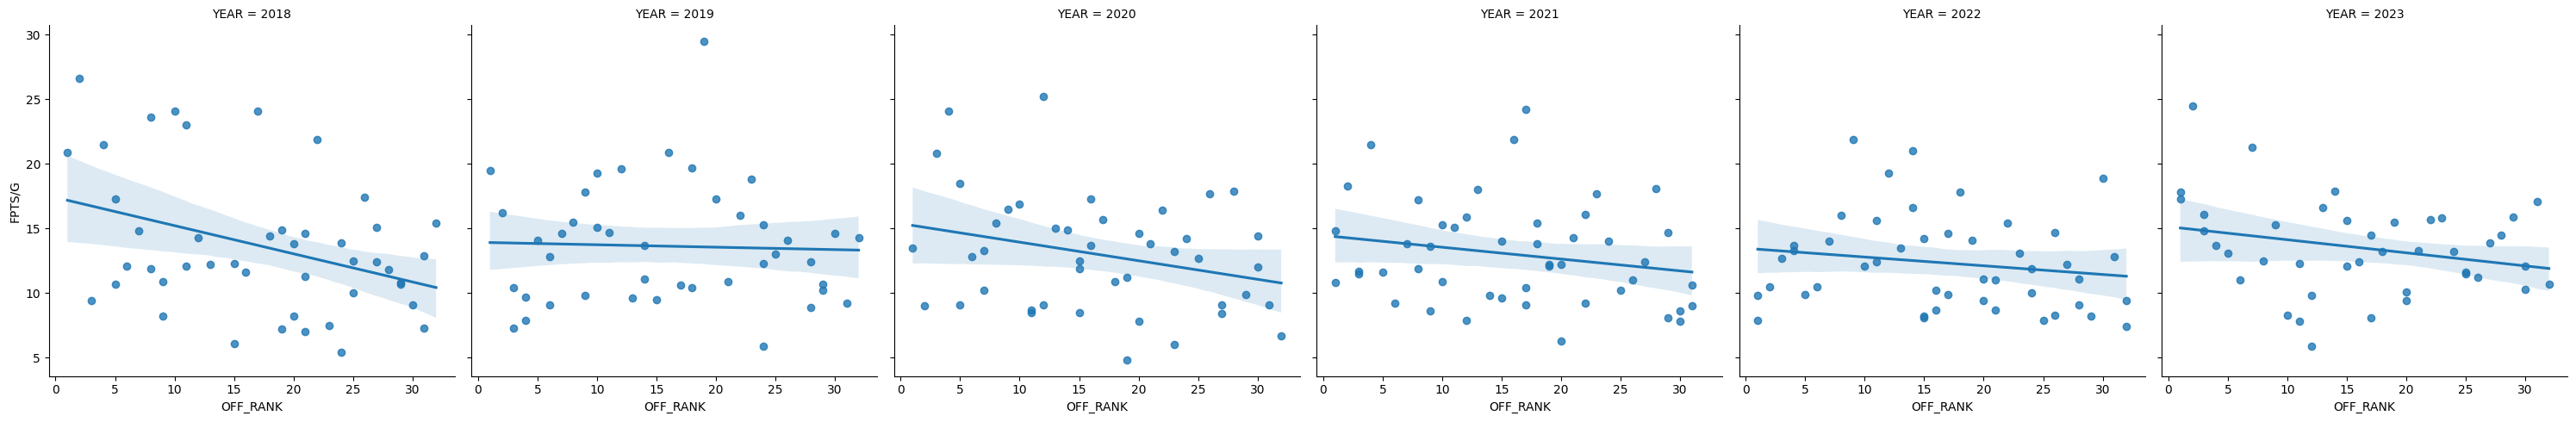

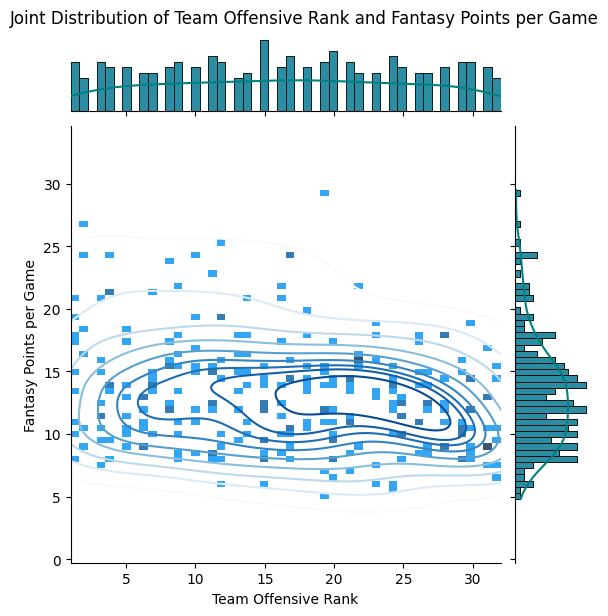

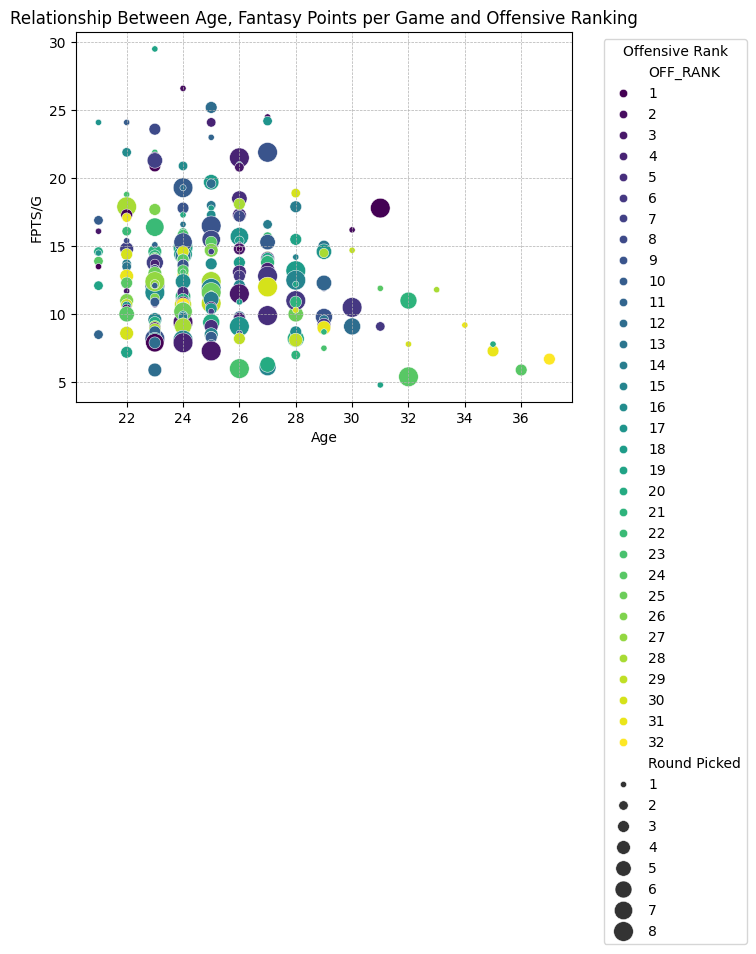

In [116]:
sns.lmplot(x = 'OFF_RANK', y = 'FPTS/G', data = PPR_RB_Fantasy_Data_2018_2023, col = 'YEAR')
plt.show()


g = sns.JointGrid(PPR_RB_Fantasy_Data_2018_2023, x = 'OFF_RANK', y = 'FPTS/G')
g.plot(sns.histplot, sns.histplot, bins=50)
g.plot_joint(sns.kdeplot, cmap="Blues")
g.plot_marginals(sns.histplot, kde=True, bins=50, color='teal')
g.ax_joint.set_xlim(1, 32)
g.set_axis_labels('Team Offensive Rank', 'Fantasy Points per Game')
g.fig.suptitle('Joint Distribution of Team Offensive Rank and Fantasy Points per Game', y=1.02)
plt.show()



bubble_plot = sns.scatterplot(
    x='AGE',
    y='FPTS/G',
    size='Round Picked',
    hue='OFF_RANK',
    palette='viridis',
    sizes=(20, 200),
    data=PPR_RB_Fantasy_Data_2018_2023,
    legend='full'
)

plt.title('Relationship Between Age, Fantasy Points per Game and Offensive Ranking')
plt.xlabel('Age')
plt.ylabel('FPTS/G')
plt.legend(title='Offensive Rank',  bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


### Further Comparison Of Select Variables
Now to see the medians and better see the distributions of stats such as TOT_YDS/G and FPTS/G, we will plot some boxplots to see the distributions of these stats by 'AGE' and 'Round Picked'. The first plot will visualize the distributions of total yards per game by different ages to see trends and, similarly, the second boxplot will do so with fantasy points per game and different ages. We want to find what ages are best when it comes to producing these two crucial stats that pretty much go hand in hand. The next two graphs attempts to do the same with FPTS/G as age did, but will be done with 'Round Picked' and if the player is a 'Majority Starter' or not instead.

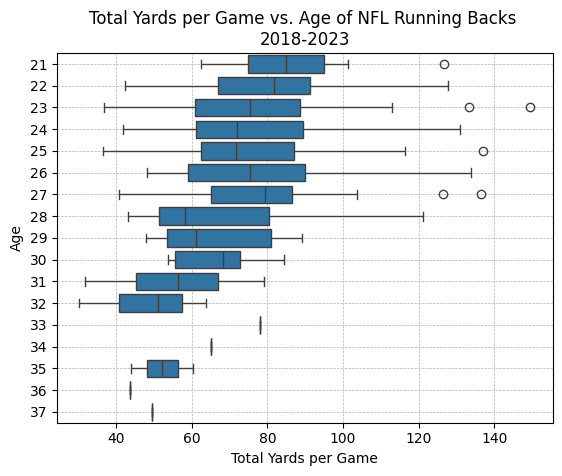

     count       mean        std    min      25%     50%      75%     max
AGE                                                                      
21    10.0  86.758000  18.675308  62.33  74.8000  85.010  94.9175  126.75
22    24.0  81.876250  21.043324  42.36  66.9025  81.615  91.2900  127.71
23    45.0  77.188000  23.840102  36.93  60.7500  75.460  88.6700  149.50
24    45.0  76.684000  21.086042  41.81  61.1400  71.940  89.4000  130.79
25    43.0  75.898372  21.950263  36.56  62.3200  71.560  86.9600  137.00
26    30.0  77.836000  20.944377  48.18  58.9150  75.400  90.0000  133.81
27    23.0  79.187826  22.569629  40.81  64.9750  79.330  86.4850  136.38
28    15.0  67.725333  22.167269  43.14  51.2900  58.240  80.3100  121.00
29    12.0  65.277500  15.272665  47.88  53.4675  61.210  80.9250   89.18
30     5.0  66.940000  12.709902  53.71  55.4700  68.310  72.8800   84.33
31     4.0  55.850000  20.088790  31.73  45.2000  56.270  66.9200   79.13
32     3.0  48.386667  16.869370  30.3

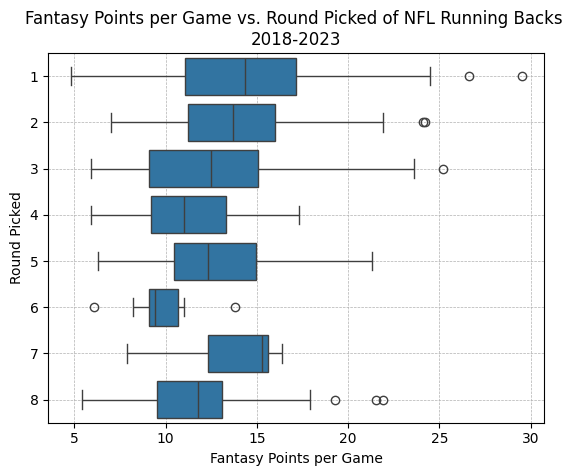

              count       mean       std  min     25%    50%     75%   max
Round Picked                                                              
1              58.0  14.612069  5.137071  4.8  11.050  14.35  17.125  29.5
2              57.0  14.038596  3.889397  7.0  11.200  13.70  16.000  24.2
3              60.0  12.700000  4.243320  5.9   9.075  12.50  15.075  25.2
4              29.0  11.475862  2.677239  5.9   9.200  11.00  13.300  17.3
5              15.0  13.073333  4.243898  6.3  10.450  12.30  14.950  21.3
6               9.0   9.688889  2.107394  6.1   9.100   9.40  10.700  13.8
7               7.0  13.628571  3.251520  7.9  12.300  15.30  15.600  16.4
8              30.0  12.246667  4.203671  5.4   9.525  11.75  13.100  21.9


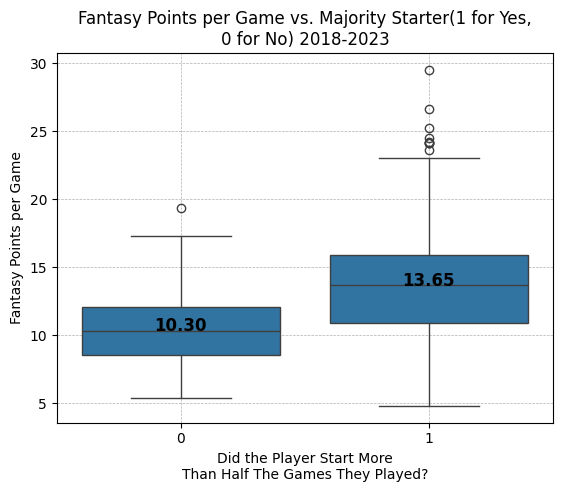

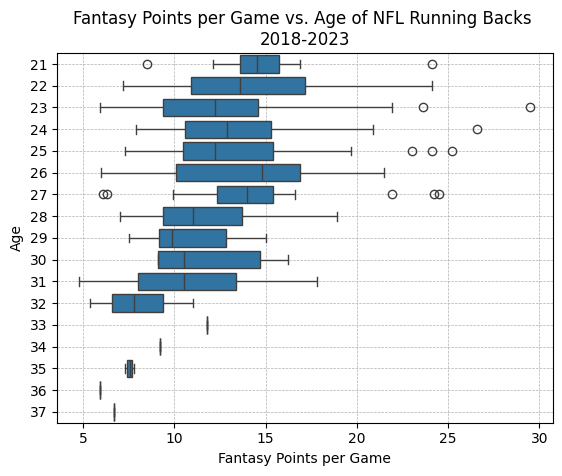

     count       mean       std   min     25%    50%     75%   max
AGE                                                               
21    10.0  14.890000  3.973929   8.5  13.600  14.55  15.750  24.1
22    24.0  14.120833  4.144979   7.2  10.925  13.60  17.150  24.1
23    45.0  13.160000  4.932609   5.9   9.400  12.20  14.600  29.5
24    45.0  13.388889  3.795285   7.9  10.600  12.90  15.300  26.6
25    43.0  13.290698  4.396038   7.3  10.450  12.20  15.400  25.2
26    30.0  14.006667  4.162553   6.0  10.075  14.80  16.900  21.5
27    23.0  14.247826  4.554904   6.1  12.350  14.00  15.400  24.5
28    15.0  11.906667  3.543095   7.0   9.350  11.00  13.700  18.9
29    12.0  11.000000  2.577878   7.5   9.150   9.85  12.850  15.0
30     5.0  11.920000  3.315419   9.1   9.100  10.50  14.700  16.2
31     4.0  10.900000  5.448547   4.8   8.025  10.50  13.375  17.8
32     3.0   8.066667  2.809508   5.4   6.600   7.80   9.400  11.0
33     1.0  11.800000       NaN  11.8  11.800  11.80  11.800  

In [117]:
#boxplot of 'AGE' and 'TOT_YDS/G'
sns.boxplot(y = 'AGE', x = 'TOT_YDS/G', data = PPR_RB_Fantasy_Data_2018_2023, orient = 'h')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('Total Yards per Game')
plt.ylabel('Age')
plt.title('Total Yards per Game vs. Age of NFL Running Backs \n2018-2023')
plt.show()
print(PPR_RB_Fantasy_Data_2018_2023.groupby('AGE')['TOT_YDS/G'].describe())

#boxplot of 'Round Picked' and 'FPTS/G'
sns.boxplot(y = 'Round Picked', x = 'FPTS/G', data = PPR_RB_Fantasy_Data_2018_2023, orient = 'h')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('Fantasy Points per Game')
plt.ylabel('Round Picked')
plt.title('Fantasy Points per Game vs. Round Picked of NFL Running Backs \n2018-2023')
plt.show()
print(PPR_RB_Fantasy_Data_2018_2023.groupby('Round Picked')['FPTS/G'].describe())

#boxplot of 'FPTS/G' and 'Majority Starter'
ax = sns.boxplot(y='FPTS/G', x='Majority Starter', data=PPR_RB_Fantasy_Data_2018_2023)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('Did the Player Start More\nThan Half The Games They Played?')
plt.ylabel('Fantasy Points per Game')
plt.title('Fantasy Points per Game vs. Majority Starter(1 for Yes,\n0 for No) 2018-2023')

# calculate medians for each category and add them to boxplot
medians = PPR_RB_Fantasy_Data_2018_2023.groupby('Majority Starter')['FPTS/G'].median()
for i, median in enumerate(medians):
    ax.text(i, median, f'{median:.2f}', horizontalalignment='center', size=12, color='black', weight='semibold')
plt.show()

#boxplot of 'AGE' and 'FPTS/G'
sns.boxplot(y = 'AGE', x = 'FPTS/G', data = PPR_RB_Fantasy_Data_2018_2023, orient = 'h')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('Fantasy Points per Game')
plt.ylabel('Age')
plt.title('Fantasy Points per Game vs. Age of NFL Running Backs \n2018-2023')
plt.show()
print(PPR_RB_Fantasy_Data_2018_2023.groupby('AGE')['FPTS/G'].describe())

Looking at the first two graphs and their associated tables, it appears that players tend to perform best in their age 21 and 22 seasons, do fairly well for the next 3 years, start to increase play again and perhaps hit peaks in the age 26 and 27 seasons, then slowly decline each year after. Younger running backs undoubtedly performed better in both TOT_YDS/G and FPTS/G in their younger seasons, perhaps first 5 to 6 years in the NFL, but then put their best football behind them once they basically turn 28 years old. Both of these categories steeply drop at this point, with lower medians, means, maxes, and minumums being achieved.

Logically, the next graph shows that players who start the majority of games they played scored on average 3 points more than players who did not start most of the games that they played in. There is greater spread for the starters, which are denoted by the number 1, along with more positive outlier values and FPTS/G values above 20. It is safe to say that if a player is a starter, they will likely score more than someone who is involved in an offense but is not a starter.

The last graph is a bit more intriguing in the results, as one might expect that the later a draft goes the less talent and potential the players may hold, thus meaning that each additional round would have a lower median FPTS/G mark. This seems to be true for the first four rounds of the draft, but the later rounds and undrafted players go a bit differently. Yes, the 5th, 6th, and 7th rounds have much lower total players in the data, which makes sense because most players drafted in these rounds tend to not become as impactful players as the first few rounders, hence why there are less. But a reason for why the medians may be so high is that these players have to do so much in training camp, practice, and games to prove and propel themselves that they have to go above and beyond what is expected of them in order to play above players with much more investing and draft capital put into them. This explains why the median may be high, but looking at the 6th rounders, the median still is very low. What can explain this is that late rounders are simply volatile, and while early rounders are safer bets as you know what you may get, later rounders are more hit or miss with lower ceilings and lower floors, but could still be better than many early round options. The undrafted players' median is still fairly high as well and with many more occurences, well with the data we have, we might be able to say that if an undrafted player makes it to become an impact player on a team as a running back, their fantasy comparison is to that of an in between 3rd and 4th rounder.

### Further Draft Round Comparison
The histogram below shows the percentage and count of players drafted from each round or not drafted at all (denoted as round 8). The later rounds had fewer players, and far further unique players, as the data contains many of the same players occuring just across different years. We can view the data below to see if any player outliers were skewing the average.

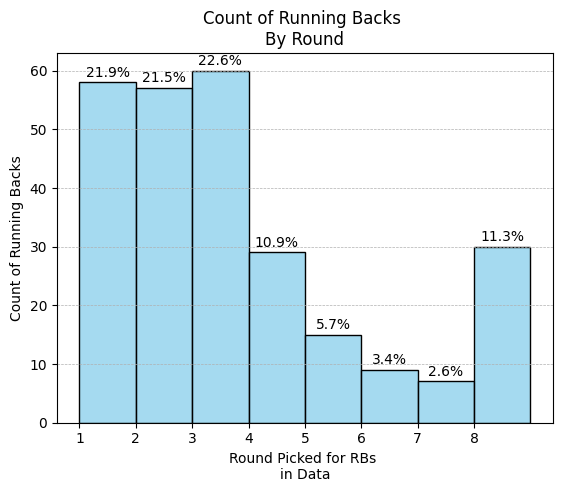

Round Picked
1    18
2    21
3    20
4    16
5     7
6     5
7     3
8    15
Name: Player, dtype: int64
             Player  FPTS/G
16      Aaron Jones    14.3
29    Jordan Howard    11.3
30     Alex Collins    10.9
34       Dion Lewis    10.0
53   Kyren Williams    21.3
57      Aaron Jones    19.7
64      Aaron Jones    18.5
104     Aaron Jones    15.3
114     Aaron Jones    14.6
158     Jerome Ford    12.4
162     Aaron Jones    12.3
184   Jordan Howard    11.1
207  Tyler Allgeier    10.0
249  Tyler Allgeier     8.1
260    Alex Collins     6.3
              Player  FPTS/G
33    Elijah McGuire    10.7
37   Latavius Murray     8.2
43       Alfred Blue     6.1
133  Elijah Mitchell    13.8
185  Latavius Murray    11.0
214  Latavius Murray     9.8
220   Khalil Herbert     9.4
226  Latavius Murray     9.1
229   Khalil Herbert     9.1
            Player  FPTS/G
15    Chris Carson    14.4
84    Myles Gaskin    16.4
94    Chris Carson    15.7
98    Chris Carson    15.5
102  Isiah Pacheco    1

In [118]:
bins = np.arange(0.5, 9.5, 1)

#histogram of count of running backs by round drafted in the data
round_counts = PPR_RB_Fantasy_Data_2018_2023['Round Picked'].value_counts().sort_index()
total_players = len(PPR_RB_Fantasy_Data_2018_2023)
percentages = (round_counts / total_players) * 100

histplot = sns.histplot(PPR_RB_Fantasy_Data_2018_2023['Round Picked'], kde=False, bins=range(1, 10), color='skyblue')

#annotates with percentages
for patch in histplot.patches:
    height = patch.get_height()
    x = patch.get_x() + patch.get_width() / 2
    round_num = int(patch.get_x() + patch.get_width() / 2)
    if round_num in percentages.index:
        percentage = percentages[round_num]
        plt.text(x, height + 0.5, f'{percentage:.1f}%', ha='center', va='bottom')

plt.xticks(range(1, 9))
plt.grid(True, axis='y', linestyle='--', linewidth=0.5)
plt.xlabel('Round Picked for RBs \nin Data')
plt.ylabel('Count of Running Backs')
plt.title('Count of Running Backs \nBy Round')
plt.show()

print(PPR_RB_Fantasy_Data_2018_2023.groupby('Round Picked')['Player'].nunique())


print(PPR_RB_Fantasy_Data_2018_2023[PPR_RB_Fantasy_Data_2018_2023['Round Picked']==5][['Player', 'FPTS/G']])
print(PPR_RB_Fantasy_Data_2018_2023[PPR_RB_Fantasy_Data_2018_2023['Round Picked']==6][['Player', 'FPTS/G']])
print(PPR_RB_Fantasy_Data_2018_2023[PPR_RB_Fantasy_Data_2018_2023['Round Picked']==7][['Player', 'FPTS/G']])
print(PPR_RB_Fantasy_Data_2018_2023[PPR_RB_Fantasy_Data_2018_2023['Round Picked']==8][['Player', 'FPTS/G']])

From this we notice that Aaron Jones may have been uplifting the fifth round average FPTS/G himself, being that he has 5 of the top 6 scoring years for the relatively small and otherwise low scoring group. Without Aaron Jones, the data may have progressed as we thought with the fifth round having an average right between that of the fourth and sixth rounds. Alternatively, we can look at the seventh round and see only three players in it, who make up only 2.6% of the total data. Yet, they still all had fairly good years which explains their high average score. The undrafted 'round' that we will call it had numerous decent scorers, yet the six Austin Ekeler years with three being above 19.3 FPTS/G definitely contributed to the '8' value in our data to be the a fairly high scoring group of players.
### Primary Predicting

We have now seen a decent amount of visualizations and data that can help us build predictions for the top contributing statistical factors in predicting PPR fantasy points per game for running backs. All of the groups in the above data have different medians, means, standard deviations, etc. for each group that a running back may belong (ex. '2nd round pick', 28 years old). Given any single predictor, we can calculate projected FPTS/G depending on where the player falls in that category. Let's take OFF_RANK for example. We can predict each player's projected FPTS/G just by looking at what their teams OFF_RANK may be. Below are the fantasy points per game predictions for all 32 offensive yardage rankings. We can easily predict this, and can see, marked in red on the linear regression line, where the points lie within the data. The regression results and residual plot that shows the difference between actual and predicted values are also shown.

Intercept    14.921246
OFF_RANK     -0.106577
dtype: float64
    OFF_RANK     FPTS_G
0          1  14.814669
1          2  14.708091
2          3  14.601514
3          4  14.494936
4          5  14.388359
5          6  14.281782
6          7  14.175204
7          8  14.068627
8          9  13.962049
9         10  13.855472
10        11  13.748894
11        12  13.642317
12        13  13.535740
13        14  13.429162
14        15  13.322585
15        16  13.216007
16        17  13.109430
17        18  13.002852
18        19  12.896275
19        20  12.789697
20        21  12.683120
21        22  12.576543
22        23  12.469965
23        24  12.363388
24        25  12.256810
25        26  12.150233
26        27  12.043655
27        28  11.937078
28        29  11.830501
29        30  11.723923
30        31  11.617346
31        32  11.510768


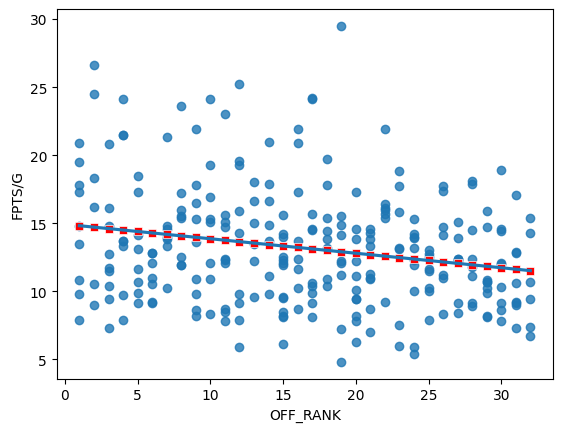

                            OLS Regression Results                            
Dep. Variable:                 FPTS_G   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     13.87
Date:                Thu, 01 Aug 2024   Prob (F-statistic):           0.000239
Time:                        04:03:53   Log-Likelihood:                -755.05
No. Observations:                 265   AIC:                             1514.
Df Residuals:                     263   BIC:                             1521.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     14.9212      0.537     27.763      0.0

<Axes: xlabel='OFF_RANK', ylabel='FPTS/G'>

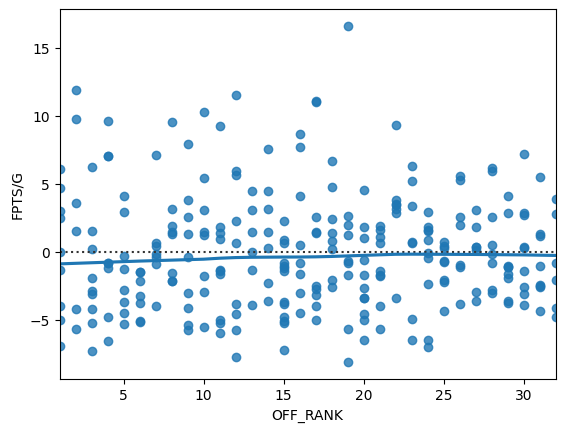

In [119]:
z = PPR_RB_Fantasy_Data_2018_2023
z_renamed = z.rename(columns={'FPTS/G': 'FPTS_G'})
#fitting ols model
mdl_offr_vs_ptsg = ols("FPTS_G ~ OFF_RANK", data=z_renamed).fit()
#prints the model parameters
print(mdl_offr_vs_ptsg.params)
explan_data = pd.DataFrame({'OFF_RANK': np.arange(1,33)})
predict_data = explan_data.assign(FPTS_G = mdl_offr_vs_ptsg.predict(explan_data))
#prints predicted values based off of OFF_RANK vs. FPTS/G
print(predict_data)
fig = plt.figure()

#regression plot of the data
sns.regplot(x='OFF_RANK', y = 'FPTS/G', data = z, ci = None)
#draws red points on linreg line
sns.scatterplot(x='OFF_RANK', y = 'FPTS_G', data = predict_data, color = 'red', marker = 's')
plt.show()
print(mdl_offr_vs_ptsg.summary())
print('mse: ', mdl_offr_vs_ptsg.mse_resid)
print('rse: ', np.sqrt(mdl_offr_vs_ptsg.mse_resid))
sns.residplot(x='OFF_RANK', y = 'FPTS/G', data = PPR_RB_Fantasy_Data_2018_2023, lowess = True)

Above, the equation for the regression line is the same as the one in which we saw on the earlier linear regression plot with OFF_RANK and FPTS/G for the dataframe being used. So, it should be no surprise that the predicted values follow the equation. We can also see this on the linear regression plot by the predicted red values lying directly on the regression line. To see how helpful OFF_RANK is in accurately predicting FPTS/G let's look into the OLS Regression Results and the R-squared value. On the right hand side, one can see that the value is 0.050, which is incredibly low. The R-squared value, or coeffecient of determination, tells us how much of the model's predictions much the actual data points, or in other terms 'the proportion of variance in the dependent variable that can be explained by the independent variable'. Values fall between 0 and 1 and this value tells us that this model does not explain much of the variablilty and should not really be used to predict solely at all.

Below the table we can see the MSE (mean squared error) and RSE (residual standard error) values, and these are not where we want them to be either. But, while one category on its own may not be able to predict FPTS/G effectively, a group of a thoughtfully selected few may be able to.
### Machine Learning to Predict FPTS/G
The strategy we will use to achieve this is machine learning, which will train our select features to give the best prediction possible. Through feature engineering, I created a few features that could also be useful to capture each player's past indvidual statistics and trends from the dataframe in addition to all of the player's 2023 statistics. As we will be predicting the top about 40 projected PPR running backs for the 2024 season, as each year in the data has about 40 players, 2023 statistics and past personal player trends will be of some of the most importance. To get potentially stronger predictions, I will manually input the player names of [fantasy pros' projected top 40 scorers](https://www.fantasypros.com/nfl/rankings/ppr-rb-cheatsheets.php), their ages for the upcoming season, whether ESPN has them as of the first day of training camp as the primary starter, the round the player was drafted in, and the [projected offense and team rankings](https://www.vegasinsider.com/nfl/odds/win-totals/) given by the average of Las Vegas' top 7 sportsbooks (as one should know, Vegas knows much more than we think we might). Below is the feature engineering, training of the data, displaying the predictions, and displaying the importance of each feature in the predictions.

In [106]:
# Grouping by Player to get aggregate stats
player_agg_stats = PPR_RB_Fantasy_Data_2018_2023.groupby('Player').agg({
    'FPTS/G': ['mean', 'std']
}).reset_index()
player_agg_stats.columns = ['Player', 'avg_FPTS/G', 'std_FPTS/G']


# Calculating trends
PPR_RB_Fantasy_Data_2018_2023['prev_YDS'] = PPR_RB_Fantasy_Data_2018_2023.groupby('Player')['TOT_YDS'].shift(1)
PPR_RB_Fantasy_Data_2018_2023['prev_FPTS/G'] = PPR_RB_Fantasy_Data_2018_2023.groupby('Player')['FPTS/G'].shift(1)

PPR_RB_Fantasy_Data_2018_2023['pct_change_YDS'] = (PPR_RB_Fantasy_Data_2018_2023['TOT_YDS'] - PPR_RB_Fantasy_Data_2018_2023['prev_YDS'])/(
                                                   PPR_RB_Fantasy_Data_2018_2023['prev_YDS'])
PPR_RB_Fantasy_Data_2018_2023['pct_change_FPTS/G'] = (PPR_RB_Fantasy_Data_2018_2023['FPTS/G'] - PPR_RB_Fantasy_Data_2018_2023['prev_FPTS/G'])/(
                                                      PPR_RB_Fantasy_Data_2018_2023['prev_FPTS/G'])


PPR_RB_Fantasy_Data_2018_2023['starter_age_interaction'] = (PPR_RB_Fantasy_Data_2018_2023['Majority Starter']) * (
                                                            PPR_RB_Fantasy_Data_2018_2023['AGE'])

# Merging aggregate stats and trends back into the main dataframe
PPR_RB_Fantasy_Data_2018_2023 = PPR_RB_Fantasy_Data_2018_2023.merge(player_agg_stats, on='Player', how='left')

# Fill NaN values with 0 for aggregate stats
PPR_RB_Fantasy_Data_2018_2023 = PPR_RB_Fantasy_Data_2018_2023.fillna(0)



PPR_RB_Fantasy_Data_2018_2023['TD/G'] = PPR_RB_Fantasy_Data_2018_2023['TOT_TD'] / PPR_RB_Fantasy_Data_2018_2023['G']

features = ['AGE', 'YDS', 'REC', 'YDS.1', '20+/G', 'OFF_RANK', 'YD/TCH', 'TCH/G', 'TOT_TD',
            'TOT_YDS/G',  'FPTS/G', 'avg_FPTS/G', 'Round Picked', 'Majority Starter']

target = 'FPTS/G'
# Splitting the data
X = PPR_RB_Fantasy_Data_2018_2023[features]
y = PPR_RB_Fantasy_Data_2018_2023[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Imputer for missing values
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Training the model
model = RandomForestRegressor(n_estimators=400,  random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
# Calculate metrics


print("R-squared:", r2_score(y_test, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", (mean_squared_error(y_test, y_pred))**0.5)


# New data preparation
new_data = pd.DataFrame({
    'Player': ['Christian McCaffrey', 'Saquon Barkley', 'Jahmyr Gibbs', 'Breece Hall', 'Bijan Robinson',
    'Kyren Williams', 'Jonathan Taylor', 'Travis Etienne Jr.', 'Derrick Henry', 'Isiah Pacheco',
    'Rachaad White', 'Devon Achane', 'Alvin Kamara', 'Josh Jacobs', 'Joe Mixon', 'James Cook',
    'Kenneth Walker III', 'Aaron Jones', 'Rhamondre Stevenson', 'James Conner',

    'Raheem Mostert', 'David Montgomery', 'Austin Ekeler',
               'Zack Moss', 'Zamir White', "D'Andre Swift",
               'Jaylen Warren', 'Najee Harris', 'Tony Pollard', 'Tyjae Spears', 'Javonte Williams',

               'Brian Robinson', 'Devin Singletary', 'Ezekiel Elliott', 'Jonathon Brooks'],
    'AGE': [28, 27, 22, 23, 22, 24, 25, 25, 30, 25, 25, 23, 29, 26, 28, 25, 24, 30, 26, 29,
            32, 27, 29,
            27, 25, 27, 26, 26, 27, 23, 24,
            25, 27, 29, 21],
    'Round Picked': [1, 1, 1, 2, 1, 5, 2, 1, 2, 7, 3, 3, 3, 1, 2, 2, 2, 5, 4, 3,
                     8, 3, 8,
                     3, 4, 2, 8, 1, 4, 3, 2,
                     3, 3, 1, 2],
    'OFF_RANK': #[1, 5, 3, 13, 17, 11, 16, 19, 6, 2, 22, 4, 24, 10, 12, 8, 14, 25, 32, 18,
                 #4, 3, 28],
    [1, 3, 5, 10, 11, 18, 16, 20, 4, 2, 23, 9, 25, 13, 12, 6, 24, 26, 32, 22,
                 9, 5, 28,
     7, 27, 14, 18, 18, 29, 29, 31,
     28, 26, 8, 30],
    'Majority Starter': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                         0, 0, 0,
                         1, 1, 1, 0, 1, 1, 0, 1,
                         1, 1, 1, 0],  # 1 means that they are the projected starter
})
new_data['YEAR'] = 2024

# Merge with aggregate stats
new_data = new_data.merge(player_agg_stats, on='Player', how='left')


# Merge with joined_rb_ftsy1 to get previous year data
new_data = new_data.merge(PPR_RB_Fantasy_Data_2018_2023[['Player', 'YEAR', 'AGE', 'OFF_RANK', 'TOT_YDS', 'FPTS/G', 'Round Picked']],
                          on=['Player', 'YEAR'], how='left', suffixes=('', '_prev'))

# Check columns to see if they exist
print(new_data.columns)  # Make sure these columns exist

# Ensure that the columns like 'TOT_YDS_prev' and 'FPTS/G_prev' exist before assigning
if 'TOT_YDS_prev' in new_data.columns:
    new_data['prev_YDS'] = new_data['TOT_YDS_prev']
else:
    new_data['prev_YDS'] = 0  # Default value if column is missing

if 'FPTS/G_prev' in new_data.columns:
    new_data['prev_FPTS/G'] = new_data['FPTS/G_prev']
else:
    new_data['prev_FPTS/G'] = 0  # Default value if column is missing

# Calculate percentage changes
new_data['pct_change_YDS'] = (new_data['TOT_YDS'] - new_data['prev_YDS']) / new_data['prev_YDS']
new_data['pct_change_FPTS/G'] = (new_data['FPTS/G'] - new_data['prev_FPTS/G']) / new_data['prev_FPTS/G']

# Fill NaN values with 0 for percentage changes
new_data['pct_change_YDS'] = new_data['pct_change_YDS'].fillna(0)
new_data['pct_change_FPTS/G'] = new_data['pct_change_FPTS/G'].fillna(0)


# Add any missing features for new data that were used in the model
for feature in features:
    if feature not in new_data.columns:
        new_data[feature] = 0

# Impute missing values in new data
new_data = imputer.transform(new_data[features])

new_data = scaler.transform(new_data)

# Predict with the trained model
predictions_fixed = ((((model.predict(new_data) * 1.2) - 15.7) + 0.1) * 100)
predictions = model.predict(new_data)


# Prepare the results with player names and predicted FPTS/G
results = pd.DataFrame({
    'Player': ['Christian McCaffrey', 'Saquon Barkley', 'Jahmyr Gibbs', 'Breece Hall', 'Bijan Robinson',
               'Kyren Williams', 'Jonathan Taylor', 'Travis Etienne Jr.', 'Derrick Henry', 'Isiah Pacheco',
               'Rachaad White', 'Devon Achane', 'Alvin Kamara', 'Josh Jacobs', 'Joe Mixon', 'James Cook',
               'Kenneth Walker III', 'Aaron Jones', 'Rhamondre Stevenson', 'James Conner',

              'Raheem Mostert', 'David Montgomery', 'Austin Ekeler', 'Zack Moss', 'Zamir White',
               "D'Andre Swift", 'Jaylen Warren', 'Najee Harris', 'Tony Pollard', 'Tyjae Spears',
               'Javonte Williams',
               'Brian Robinson', 'Devin Singletary', 'Ezekiel Elliott', 'Jonathon Brooks'],
    'Predicted FPTS/G': predictions,
    'Fixed Pred FPTS/G': predictions_fixed
})

# Print the results
results = results.sort_values(by='Predicted FPTS/G', ascending=False)
results = results.reset_index(drop=True)
print(results)

importances = pd.Series(model.feature_importances_, index=features)
importances = importances.sort_values(ascending=False)
print(importances)

R-squared: 0.9822161902435209
Mean Absolute Error: 0.1351968750000004
Mean Squared Error: 0.29367713828123215
Root Mean Squared Error: 0.5419198633388816
Index(['Player', 'AGE', 'Round Picked', 'OFF_RANK', 'Majority Starter', 'YEAR',
       'avg_FPTS/G', 'std_FPTS/G', 'AGE_prev', 'OFF_RANK_prev', 'TOT_YDS',
       'FPTS/G', 'Round Picked_prev'],
      dtype='object')
                 Player  Predicted FPTS/G  Fixed Pred FPTS/G
0          Jahmyr Gibbs          13.13475              16.17
1        Bijan Robinson          13.13350              16.02
2           Breece Hall          13.13350              16.02
3         Derrick Henry          13.13175              15.81
4        Saquon Barkley          13.13075              15.69
5   Christian McCaffrey          13.13075              15.69
6      David Montgomery          13.13050              15.66
7             Joe Mixon          13.13050              15.66
8            James Cook          13.13000              15.60
9         D'Andre Sw

At the very beginning of the long lists of numbers, the R-squared, Mean Absolute Error, Mean Squared Error, and Root Mean Squared Error values can be seen at the top. Now with the R-squared being 0.982 and the other errors being significantly lower than with the single feature predictor, we can deduce that this model is a better fit. However, the unfortunate thing is that all of the players' projected FPTS/G are incredibly and almost indistinguishably different from any other player. This is not realistic to what will inevitably occur in the real world, without even mentioning injuries or unforeseen teams having horrible offenses, as these values will never be this close in real life. The model is conservative in this way, but the odds that it predicts more players correctly is higher if it is conservative like this. Still, I implemented a scaling equation for the predictions and placed it to the right of the predicted values if one would prefer it that way.

The predicted values are not incredibly consistent with that of the experts' fantasy predictions, as almost none of the fantasy points are exactly right and the rankings are not super close. Christian McCaffrey is not RB1 in these predictions and other early round players like Kyren Williams, Jonathan Taylor, and Devon Achane are lower in their rank than they should be. Later round players like Ezekiel Elliott and Raheem Mostert are also much higher than they would be if this was an experts' rankings. But, I am no expert, and had little personal say in how these rankings would come out so do not be offended.

An interesting factor of the data that was produced was that of the importance values. FPTS/G for each player was far and away the most valuable predictor at 99.57% of the tally, but this makes sense as past FPTS/G would be best numerical stat for predicting the future's. Do not be fooled however, as when I was undergoing feature engineering and getting lower R-squared values, implementing features with even 0.00002 importance greatly mixed up the rankings and the predicted scores, of which the data looked entirely different. The features used here the ones that had a high value of correlation with FPTS/G, even if the high value only existed for a subset of the entire dataframe, anything that could affect FPTS/G should be used

While this prediction does have its faults, most of the top predictors are the ones that experts agree with are top 5 or top 10 players, such as Breece Hall, Bijan Robinson, Derrick Henry, and Saquon Barkley being in reasonable spots along with others. Yet, after creation of this prediction I found another way to get an even better prediction with better testing stats such as R-squared, MSE, and RSE. The predictions are below.

In [107]:
PPR_RB_Fantasy_Data_2018_2023 = PPR_RB_Fantasy_Data_2018_2023.sort_values('FPTS/G', ascending = False)



# Splitting the data
X = PPR_RB_Fantasy_Data_2018_2023[features]
y = PPR_RB_Fantasy_Data_2018_2023[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



# Imputer for missing values
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Training the model
model = RandomForestRegressor(n_estimators=400,  random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
# Calculate metrics


print("R-squared:", r2_score(y_test, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", (mean_squared_error(y_test, y_pred))**0.5)


# New data preparation
new_data = pd.DataFrame({
    'Player': ['Christian McCaffrey', 'Saquon Barkley', 'Jahmyr Gibbs', 'Breece Hall', 'Bijan Robinson',
    'Kyren Williams', 'Jonathan Taylor', 'Travis Etienne Jr.', 'Derrick Henry', 'Isiah Pacheco',
    'Rachaad White', 'Devon Achane', 'Alvin Kamara', 'Josh Jacobs', 'Joe Mixon', 'James Cook',
    'Kenneth Walker III', 'Aaron Jones', 'Rhamondre Stevenson', 'James Conner',

    'Raheem Mostert', 'David Montgomery', 'Austin Ekeler',
               'Zack Moss', 'Zamir White', "D'Andre Swift",
               'Jaylen Warren', 'Najee Harris', 'Tony Pollard', 'Tyjae Spears', 'Javonte Williams',

               'Brian Robinson', 'Devin Singletary', 'Ezekiel Elliott', 'Jonathon Brooks'],
    'AGE': [28, 27, 22, 23, 22, 24, 25, 25, 30, 25, 25, 23, 29, 26, 28, 25, 24, 30, 26, 29,
            32, 27, 29,
            27, 25, 27, 26, 26, 27, 23, 24,
            25, 27, 29, 21],
    'Round Picked': [1, 1, 1, 2, 1, 5, 2, 1, 2, 7, 3, 3, 3, 1, 2, 2, 2, 5, 4, 3,
                     8, 3, 8,
                     3, 4, 2, 8, 1, 4, 3, 2,
                     3, 3, 1, 2],
    'G': [16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
          16, 16, 16,
          17, 17, 17, 17, 17, 17, 17, 17,
          17, 17, 17, 10],
    'OFF_RANK': [1, 3, 5, 10, 11, 18, 16, 20, 4, 2, 23, 9, 25, 13, 12, 6, 24, 26, 32, 22,
                 9, 5, 28,
     7, 27, 14, 18, 18, 29, 29, 31,
     28, 26, 8, 30],
    'Majority Starter': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                         0, 0, 0,
                         1, 1, 1, 0, 1, 1, 0, 1,
                         1, 1, 1, 0],  # 1 means that they are the projected starter
})
new_data['YEAR'] = 2024

# Merge with aggregate stats
new_data = new_data.merge(player_agg_stats, on='Player', how='left')


# Merge with joined_rb_ftsy1 to get previous year data
new_data = new_data.merge(PPR_RB_Fantasy_Data_2018_2023[['Player', 'YEAR', 'AGE', 'OFF_RANK', 'TOT_YDS', 'FPTS/G', 'Round Picked']],
                          on=['Player', 'YEAR'], how='left', suffixes=('', '_prev'))

# Check columns to see if they exist
print(new_data.columns)  # Make sure these columns exist

# Ensure that the columns like 'TOT_YDS_prev' and 'FPTS/G_prev' exist before assigning
if 'TOT_YDS_prev' in new_data.columns:
    new_data['prev_YDS'] = new_data['TOT_YDS_prev']
else:
    new_data['prev_YDS'] = 0  # Default value if column is missing

if 'FPTS/G_prev' in new_data.columns:
    new_data['prev_FPTS/G'] = new_data['FPTS/G_prev']
else:
    new_data['prev_FPTS/G'] = 0  # Default value if column is missing

# Calculate percentage changes
new_data['pct_change_YDS'] = (new_data['TOT_YDS'] - new_data['prev_YDS']) / new_data['prev_YDS']
new_data['pct_change_FPTS/G'] = (new_data['FPTS/G'] - new_data['prev_FPTS/G']) / new_data['prev_FPTS/G']

# Fill NaN values with 0 for percentage changes
new_data['pct_change_YDS'] = new_data['pct_change_YDS'].fillna(0)
new_data['pct_change_FPTS/G'] = new_data['pct_change_FPTS/G'].fillna(0)


# Add any missing features for new data that were used in the model
for feature in features:
    if feature not in new_data.columns:
        new_data[feature] = 0

# Impute missing values in new data
new_data = imputer.transform(new_data[features])

new_data = scaler.transform(new_data)

# Predict with the trained model
predictions = model.predict(new_data)


# Prepare the results with player names and predicted FPTS/G
results = pd.DataFrame({
    'Player': ['Christian McCaffrey', 'Saquon Barkley', 'Jahmyr Gibbs', 'Breece Hall', 'Bijan Robinson',
               'Kyren Williams', 'Jonathan Taylor', 'Travis Etienne Jr.', 'Derrick Henry', 'Isiah Pacheco',
               'Rachaad White', 'Devon Achane', 'Alvin Kamara', 'Josh Jacobs', 'Joe Mixon', 'James Cook',
               'Kenneth Walker III', 'Aaron Jones', 'Rhamondre Stevenson', 'James Conner',

              'Raheem Mostert', 'David Montgomery', 'Austin Ekeler', 'Zack Moss', 'Zamir White',
               "D'Andre Swift", 'Jaylen Warren', 'Najee Harris', 'Tony Pollard', 'Tyjae Spears',
               'Javonte Williams',
               'Brian Robinson', 'Devin Singletary', 'Ezekiel Elliott', 'Jonathon Brooks'],
    'Predicted FPTS/G': predictions
})

# Print the results
results = results.sort_values(by='Predicted FPTS/G', ascending=False)
results = results.reset_index(drop=True)
print(results)

importances = pd.Series(model.feature_importances_, index=features)
importances = importances.sort_values(ascending=False)
print(importances)

R-squared: 0.9946661537123329
Mean Absolute Error: 0.1383750000000016
Mean Squared Error: 0.08786010781249712
Root Mean Squared Error: 0.29641205746814203
Index(['Player', 'AGE', 'Round Picked', 'G', 'OFF_RANK', 'Majority Starter',
       'YEAR', 'avg_FPTS/G', 'std_FPTS/G', 'AGE_prev', 'OFF_RANK_prev',
       'TOT_YDS', 'FPTS/G', 'Round Picked_prev'],
      dtype='object')
                 Player  Predicted FPTS/G  Fixed Pred FPTS/G
0   Christian McCaffrey          13.17675              21.21
1        Saquon Barkley          13.17675              21.21
2       Ezekiel Elliott          13.17550              21.06
3         Derrick Henry          13.17225              20.67
4      David Montgomery          13.17075              20.49
5             Joe Mixon          13.16975              20.37
6             Zack Moss          13.16950              20.34
7        Raheem Mostert          13.16925              20.31
8          Jahmyr Gibbs          13.16925              20.31
9           Jo

All of the testing predictors came out much better, although now the rankings are much less consistent with consensus rankings everywhere else. Still, through observing trends in the data through visualizations and analysis we were able to choose the best features and get somewhat capable 2024 season FPTS/G predictions.

Below we can use only the features we input to the computer that were known before the season to find the highest underachievers and overachievers in the dataset, and for 2024 football implications, for last season. The only features made available to the machine learning model will be 'AGE', 'OFF_RANK', 'avg_FPTS/G', 'Round Picked', and 'Majority Starter'. While the model will still use future data for finding under and overachievers in the 2018 or 2019 and etc. seasons (I could not find the best way to exclude future data), it is still interesting to see what pops up, especially with the under and overachievers from this last season.

R-Squared: 0.5475096650613394


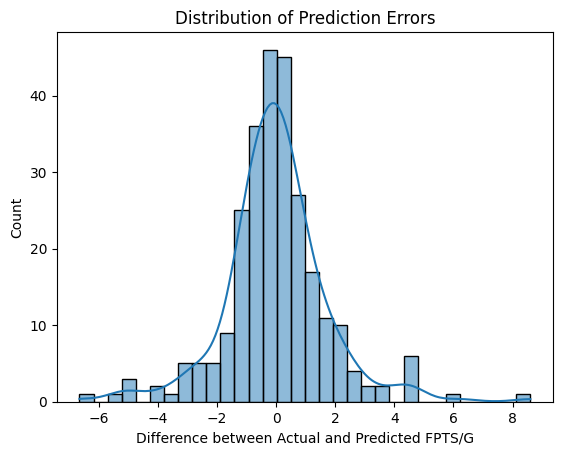

                    Player  FPTS/G  Predicted_FPTS/G  Difference  YEAR
4        Melvin Gordon III    23.0          14.39575     8.60425  2018
5          Ezekiel Elliott    21.9          15.68950     6.21050  2018
102          Isiah Pacheco    15.3          10.52775     4.77225  2023
12         Phillip Lindsay    14.9          10.41500     4.48500  2018
129          Damien Harris    14.0           9.54175     4.45825  2021
61             Josh Jacobs    19.3          14.86325     4.43675  2022
95            Tony Pollard    15.6          11.21825     4.38175  2022
45     Christian McCaffrey    29.5          25.14000     4.36000  2019
139  Darrell Henderson Jr.    13.6           9.91575     3.68425  2021
62           Derrick Henry    18.9          15.43100     3.46900  2022
                  Player  FPTS/G  Predicted_FPTS/G  Difference  YEAR
189       Todd Gurley II    10.9          17.55725    -6.65725  2020
192     David Montgomery    10.7          15.98600    -5.28600  2019
194       Sa

In [108]:
features = ['AGE', 'OFF_RANK', 'avg_FPTS/G', 'Round Picked', 'Majority Starter']
target = 'FPTS/G'

# Separate features and target
X = PPR_RB_Fantasy_Data_2018_2023[features]
y = PPR_RB_Fantasy_Data_2018_2023[target]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the model
model = RandomForestRegressor(n_estimators=400, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print("R-Squared:", r2_score(y_test, y_pred))

# Predict FPTS/G for the entire DataFrame
PPR_RB_Fantasy_Data_2018_2023['Predicted_FPTS/G'] = model.predict(X)
PPR_RB_Fantasy_Data_2018_2023['Difference'] = PPR_RB_Fantasy_Data_2018_2023['FPTS/G'] - PPR_RB_Fantasy_Data_2018_2023['Predicted_FPTS/G']

sns.histplot(PPR_RB_Fantasy_Data_2018_2023['Difference'], kde=True)
plt.xlabel('Difference between Actual and Predicted FPTS/G')
plt.title('Distribution of Prediction Errors')
plt.show()

top_errors = PPR_RB_Fantasy_Data_2018_2023[['Player', 'FPTS/G', 'Predicted_FPTS/G', 'Difference', 'YEAR']
                                           ].sort_values(by='Difference', ascending=False)
bottom_errors = PPR_RB_Fantasy_Data_2018_2023[['Player', 'FPTS/G', 'Predicted_FPTS/G', 'Difference', 'YEAR']
                                           ].sort_values(by='Difference', ascending=True)
print(top_errors.head(10))
print(bottom_errors.head(10))
print(PPR_RB_Fantasy_Data_2018_2023[PPR_RB_Fantasy_Data_2018_2023['YEAR']==2023][['Player', 'FPTS/G', 'Predicted_FPTS/G', 'Difference', 'YEAR']
                                           ].sort_values(by='Difference', ascending=False))

The R-squared is low, but that is due to the taking away of valuable features from the model. Yet, this was needed as the model would then cheat and we would not get as realistic historical predictions, using this insight we can apply this to 2024 fantasy rankings as well. If there are overvalued players such as Isiah Pacheco and Rachaad White having such overachieving years, these players would most likely revert back to their projections for the upcoming year, while underachieving players such as De'Von Achane, Jahmyr Gibbs, and, although rapidly aging, Austin Ekeler may be flowers that could potentially grow into their own and bloom this upcoming season.
### Conclusion
We have found a plethora of relationships between historic variables related to past production and historical scoring seasons from PPR fantasy football running backs. While we did predict rankings and projected FPTS/G for the coming season, we must approach these values with caution and not take them as the law, as the computer does not take into every single factor available in the real world. Still, it still is a solid baseline for prediciting running back success in PPR scoring formats and the numerous visualizations should be on ones mind when someone is having a tough time between selecting an aging running back in a bad offense or a young first round pick who is on an up and coming playoff contender. The data visualizations can no doubt assist in fantasy football journeys everywhere and should certainly be something to look at, continue to look into, and improve upon in this field of hobby.